https://www.datacamp.com/community/tutorials/xgboost-in-python

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
os.environ["PATH"] += os.pathsep + 'D:/LatexPackage/miktex/bin/x64'

In [2]:
os.environ["PATH"] += os.pathsep + 'D:/Database/Bitfinex-historical-data-master/Bitfinex-historical-data-master'

In [3]:
import warnings
warnings.filterwarnings("ignore")


In [4]:
from sklearn.datasets import load_boston

In [5]:
from pandas.plotting import scatter_matrix

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [7]:
import pylab

In [8]:
import numpy as np

import matplotlib.pyplot as plt

import datetime as dt

from datetime import datetime

import pandas as pd
import urllib.request
     

from IPython.display import clear_output

In [9]:
import seaborn as sns

In [10]:
## Loading BTC and XRP Data

In [11]:
header_format = ['timestamp_UTC_millisec',
'open_price',
'close_price',
'highest_price',
'lowest_price',
'volume']

In [12]:
BTC_USD_1min_path = 'D:\Database\Bitfinex-historical-data-master_backup\Bitfinex-historical-data-master\BTCUSD\Candles_1m'

In [13]:
BTC_2019 = pd.read_csv(BTC_USD_1min_path + '/2019/merged.csv', header=None ,names =  ['btc_' + d for d in header_format])

In [14]:
BTC_2018 = pd.read_csv(BTC_USD_1min_path + '/2018/merged.csv', header=None ,names =  ['btc_' + d for d in header_format])

In [15]:
XRP_USD_1min_path = 'D:\Database\Bitfinex-historical-data-master_backup\Bitfinex-historical-data-master\XRPUSD\Candles_1m'

In [16]:
XRP_2018 = pd.read_csv(XRP_USD_1min_path + '/2018/merged.csv', header=None, names = ['xrp_' + d for d in header_format])

In [17]:
XRP_2019 = pd.read_csv(XRP_USD_1min_path + '/2019/merged.csv', header=None , names =  ['xrp_' + d for d in header_format])

In [18]:
btc_xrp_merged_2019 = BTC_2019.merge(XRP_2019, 
               left_on = 'btc_timestamp_UTC_millisec', 
               right_on = 'xrp_timestamp_UTC_millisec', 
               how = 'outer')

In [19]:
btc_xrp_merged_2019['time_stamp_UTC_millisec'] = btc_xrp_merged_2019['xrp_timestamp_UTC_millisec']

In [20]:
btc_xrp_merged_2019['time_stamp_UTC_millisec'] = btc_xrp_merged_2019['time_stamp_UTC_millisec'].fillna(btc_xrp_merged_2019['btc_timestamp_UTC_millisec'])

In [21]:
btc_xrp_merged_2019.tail()

,btc_timestamp_UTC_millisec,btc_open_price,btc_close_price,btc_highest_price,btc_lowest_price,btc_volume,xrp_timestamp_UTC_millisec,xrp_open_price,xrp_close_price,xrp_highest_price,xrp_lowest_price,xrp_volume,time_stamp_UTC_millisec
435091,NaN,NaN,NaN,NaN,NaN,NaN,1.572598e+12,0.29248,0.29254,0.29254,0.29243,35279.507174,1.572598e+12
435092,NaN,NaN,NaN,NaN,NaN,NaN,1.572601e+12,0.29166,0.29165,0.29166,0.29165,388.265000,1.572601e+12
435093,NaN,NaN,NaN,NaN,NaN,NaN,1.572601e+12,0.29189,0.29189,0.29189,0.29183,2000.000000,1.572601e+12
435094,NaN,NaN,NaN,NaN,NaN,NaN,1.572603e+12,0.29201,0.29201,0.29201,0.29201,100.000000,1.572603e+12
435095,NaN,NaN,NaN,NaN,NaN,NaN,1.572605e+12,0.29211,0.29211,0.29211,0.29211,834.642329,1.572605e+12


# Starting of analysis

### Get 1min XRP data

In [22]:
XRP_USD_1min_path = 'D:\Database\Bitfinex-historical-data-master_backup\Bitfinex-historical-data-master\XRPUSD\Candles_1m'

In [23]:
header_format = ['timestamp_UTC_millisec',
'open_price',
'close_price',
'highest_price',
'lowest_price',
'volume']

In [24]:
xrp_2018_full = pd.read_csv(XRP_USD_1min_path + '/2018/merged.csv', header=None)

In [25]:
xrp_2019_until_Oct = pd.read_csv(XRP_USD_1min_path + '/2019/merged.csv', header=None)

In [26]:
xrp_2018_full.columns = header_format

In [27]:
xrp_2019_until_Oct.columns = header_format

In [28]:
xrp_2018_onwards = pd.concat([xrp_2018_full, xrp_2019_until_Oct])

In [29]:
XRP_Data = xrp_2018_onwards[xrp_2018_onwards['timestamp_UTC_millisec'] >= 1534287600000]

In [30]:
XRP_Data['datetime_real'] = XRP_Data['timestamp_UTC_millisec'].apply(lambda x: datetime.utcfromtimestamp(x/1000))

In [31]:
len(XRP_Data)

564561

In [32]:
XRP_Data['datetime_real'].min()

Timestamp('2018-08-14 23:00:00')

In [33]:
XRP_Data['datetime_real'].max()

Timestamp('2019-11-01 15:59:00')

In [34]:
(XRP_Data['datetime_real'].max() - XRP_Data['datetime_real'].min())

Timedelta('443 days 16:59:00')

In [35]:
XRP_Data['checking_timestamp_UTC_millisec'] = XRP_Data['timestamp_UTC_millisec'].shift(-1)

In [36]:
XRP_Data['dif'] = XRP_Data['checking_timestamp_UTC_millisec'] - XRP_Data['timestamp_UTC_millisec']

In [37]:
XRP_Data_resample_1min_ffill = XRP_Data.set_index('datetime_real').resample('1T').ffill()

In [38]:
XRP_Data_resample_1min_ffill['checking_timestamp_UTC_millisec'] = XRP_Data_resample_1min_ffill['timestamp_UTC_millisec'].shift(-1)

In [39]:
XRP_Data_resample_1min_ffill['dif'] = XRP_Data_resample_1min_ffill['checking_timestamp_UTC_millisec'] - XRP_Data_resample_1min_ffill['timestamp_UTC_millisec']

In [40]:
XRP_Data_resample_1min_ffill['timestamp_UTC'] = XRP_Data_resample_1min_ffill['timestamp_UTC_millisec']/1000

In [41]:
XRP_Data_resample_1min_ffill.head()

,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
datetime_real,,,,,,,,,
2018-08-14 23:00:00,1534287600000,0.26444,0.26427,0.26448,0.26427,21493.134691,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:01:00,1534287660000,0.26410,0.26408,0.26418,0.26408,6316.950507,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:02:00,1534287720000,0.26419,0.26429,0.26429,0.26390,15876.859198,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:03:00,1534287780000,0.26389,0.26359,0.26389,0.26359,15102.000000,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:04:00,1534287840000,0.26368,0.26359,0.26379,0.26359,6305.473357,1.534288e+12,60000.0,1.534288e+09


#### rough check on data

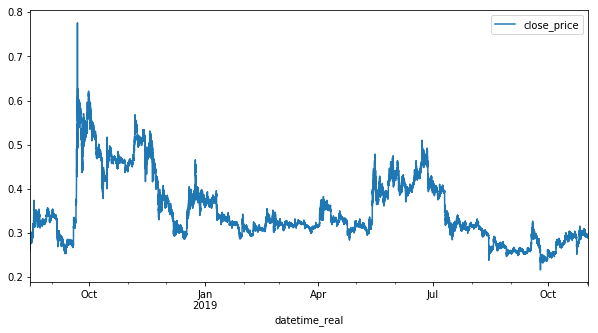

In [42]:
XRP_Data_resample_1min_ffill[['close_price']].plot(figsize = (10,5))

In [43]:
XRP_Data_resample_1min_ffill.tail(10)

,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
datetime_real,,,,,,,,,
2019-11-01 15:50:00,1572623400000,0.29032,0.29029,0.29032,0.29029,18977.229740,1.572623e+12,60000.0,1.572623e+09
2019-11-01 15:51:00,1572623460000,0.29034,0.29030,0.29035,0.29030,11583.433064,1.572624e+12,60000.0,1.572623e+09
2019-11-01 15:52:00,1572623520000,0.29070,0.29046,0.29071,0.29046,205.000000,1.572624e+12,60000.0,1.572624e+09
2019-11-01 15:53:00,1572623580000,0.29058,0.29077,0.29077,0.29046,20164.038042,1.572624e+12,0.0,1.572624e+09
2019-11-01 15:54:00,1572623580000,0.29058,0.29077,0.29077,0.29046,20164.038042,1.572624e+12,120000.0,1.572624e+09
2019-11-01 15:55:00,1572623700000,0.29083,0.29173,0.29173,0.29083,1570.393827,1.572624e+12,60000.0,1.572624e+09
2019-11-01 15:56:00,1572623760000,0.29161,0.29150,0.29161,0.29120,4022.034331,1.572624e+12,60000.0,1.572624e+09
2019-11-01 15:57:00,1572623820000,0.29180,0.29154,0.29207,0.29154,6854.915950,1.572624e+12,60000.0,1.572624e+09
2019-11-01 15:58:00,1572623880000,0.29139,0.29030,0.29151,0.29030,8296.541362,1.572624e+12,60000.0,1.572624e+09



 selecting '2018-08-15 00:00:00' as the starting time as it bypasses the past crypto rush


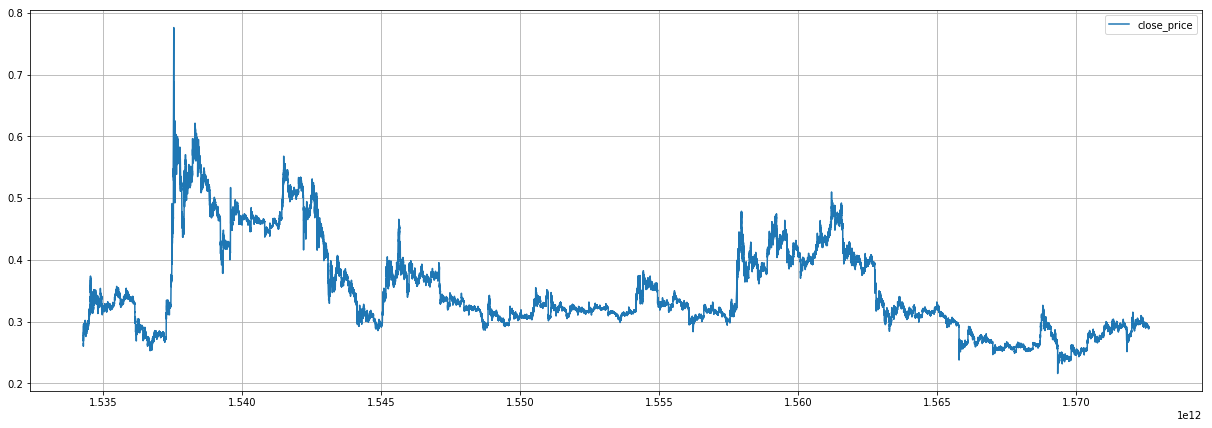

In [44]:
ploting_breakdown = XRP_Data_resample_1min_ffill.reset_index()

plt.figure(figsize= (21,7))


# tran_y_low = ploting_breakdown['low']
# tran_y_high = ploting_breakdown['high']
tran_y_close = ploting_breakdown['close_price']

tran_x = ploting_breakdown['timestamp_UTC_millisec']


# plt.plot(tran_x, tran_y_low, alpha = 0.1)
# plt.plot(tran_x, tran_y_high , alpha  = 0.1)

plt.plot(tran_x, tran_y_close, alpha  = 1)


# start = 45000
# dealta_t = 10000
time_section = {45000 : 13000,
                63000 : 8000 ,
                71000 : 10000,
                180000: 10000}  # start // delta_t



# plt.vlines(1534287600000, 0, 1, alpha = 1, color = 'g',linestyle = 'dashed')
    
plt.legend()
plt.grid()
print("\n selecting '2018-08-15 00:00:00' as the starting time as it bypasses the past crypto rush")

In [45]:
ploting_breakdown[ploting_breakdown['datetime_real'] == '2018-08-15 00:00:00']

,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
60,2018-08-15,1534291200000,0.27279,0.2734,0.27349,0.27279,17252.63782,1.534291e+12,60000.0,1.534291e+09


In [46]:
ploting_breakdown[ploting_breakdown['datetime_real'] == '2019-08-15 00:00:00']

,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
525660,2019-08-15,1565827200000,0.26373,0.26559,0.26559,0.26363,166192.961293,1.565827e+12,60000.0,1.565827e+09


## Saving Data 

In [49]:
# XRP_Data_backUp = XRP_Data_resample_1min_ffill.copy()

## Copy for testing

In [50]:
XRP_for_training =XRP_Data_resample_1min_ffill[(XRP_Data_resample_1min_ffill['timestamp_UTC'] >= 1534287600) &
                           (XRP_Data_resample_1min_ffill['timestamp_UTC'] <1565823600)].reset_index().copy()

In [51]:
XRP_for_testing =XRP_Data_resample_1min_ffill[(XRP_Data_resample_1min_ffill['timestamp_UTC'] >= 1565823600)].reset_index().copy()

In [52]:
XRP_for_testing.head()

,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
0,2019-08-14 23:00:00,1565823600000,0.27050,0.27034,0.27050,0.27032,200.000000,1.565824e+12,60000.0,1.565824e+09
1,2019-08-14 23:01:00,1565823660000,0.27034,0.27014,0.27034,0.27011,6970.610576,1.565824e+12,60000.0,1.565824e+09
2,2019-08-14 23:02:00,1565823720000,0.27015,0.27031,0.27044,0.27015,9002.533511,1.565824e+12,60000.0,1.565824e+09
3,2019-08-14 23:03:00,1565823780000,0.27028,0.27028,0.27034,0.27027,22726.951973,1.565824e+12,60000.0,1.565824e+09
4,2019-08-14 23:04:00,1565823840000,0.27015,0.26971,0.27015,0.26932,115833.923778,1.565824e+12,60000.0,1.565824e+09


In [53]:
XRP_for_testing['datetime_real'].max()

Timestamp('2019-11-01 15:59:00')

In [54]:
XRP_for_testing['datetime_real'].min()

Timestamp('2019-08-14 23:00:00')

## Analysis on training datasets

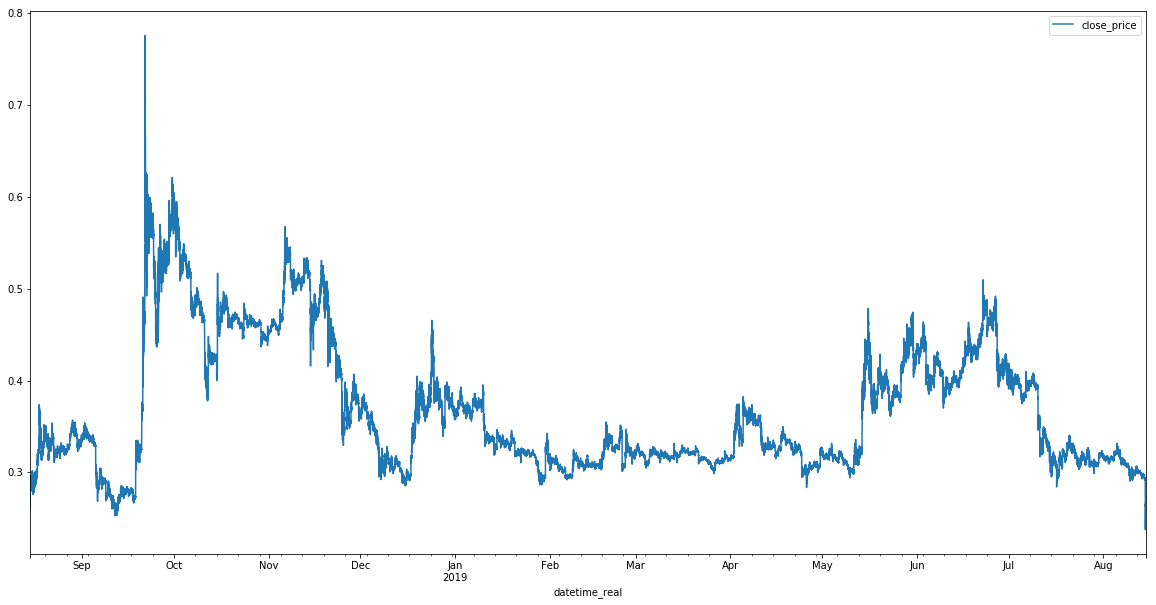

In [55]:
XRP_for_training.set_index('datetime_real')[['close_price']].plot(figsize = (20,10))

## Data mining, making own properties and features

In [56]:
section_period = {  '3min': 3,
                    '4min': 4,
                    '5min': 5,
                    '10min': 10,
                    '15min': 15,
                    '20min': 20,
                    '25min': 25,
                    '30min': 30,
                    '35min': 35,
                    '40min': 40,
                    '45min': 45,
                    '50min': 50,
                    '55min': 55,
                    '1H': 60,
                    '2H': 120,
                    '3H': 180,
                    '4H': 240,
                    '5H': 300,
                    '6H': 360,
                    '7H': 420,
                    '8H': 480,
                    '9H': 540,
                    '10H': 600,
                    '11H': 660,
                    '12H': 720,
                    '24H': 1440,
                    '2D': 2880,
                    '3D': 4320,
                    '4D': 5760,
                    '5D': 7200,
                    '10D': 14400}

In [57]:
for k,v in section_period.items():
    XRP_for_training['{0}_RA_on_Close'.format(k)] = XRP_for_training['close_price'].rolling(v).mean()

In [58]:
compare_sequence = {}

In [59]:
for col_1 in [d for d in XRP_for_training.columns if '_RA_on_Close' in d]:
    for col_2 in [d for d in XRP_for_training.columns if '_RA_on_Close' in d]:
        temp_1 = col_1.split('_RA_on_Close')[0]
        temp_2 = col_2.split('_RA_on_Close')[0]
        if temp_1 != temp_2:
            if ((temp_1 + '_minus_' + temp_2) not in compare_sequence.keys() and (temp_2 + '_minus_' + temp_1) not in compare_sequence.keys() ):
                compare_sequence.update({temp_1 + '_minus_' + temp_2 : [col_1, col_2]})

In [60]:
for k, val in compare_sequence.items():
    XRP_for_training[k] = (XRP_for_training[val[0]] - XRP_for_training[val[1]])/XRP_for_training[val[1]] 
#     print(k, val[0], val[1])

In [61]:
for col in [d for d in XRP_for_training.columns if '_RA_on_Close' in d]:
    XRP_for_training[col] = XRP_for_training[col].shift(1)
    
    XRP_for_training['{0}_close_percent_dif'.format(col.split('_RA_on_Close')[0])] = (XRP_for_training['close_price']-XRP_for_training[col])/XRP_for_training[col] 

In [62]:
for k,v in section_period.items():
    print(k,v)
    XRP_for_training['look_back_{}'.format(k)] = XRP_for_training['close_price'].shift(v)   # i.e. 20min ago, this is what the close price is
    XRP_for_training['look_forward_{}'.format(k)] = XRP_for_training['close_price'].shift(-v)  # i.e. 20min later, the close price is


for k,v in section_period.items():
    print(k,v)
    XRP_for_training['calculate_look_back_Percent_{}'.format(k)]    = 100*(XRP_for_training['close_price'] - XRP_for_training['look_back_{}'.format(k)])/(v)
    XRP_for_training['calculate_look_forward_Percent_{}'.format(k)] =  100*(XRP_for_training['look_forward_{}'.format(k)] - XRP_for_training['close_price'])/(v)

3min 3
4min 4
5min 5
10min 10
15min 15
20min 20
25min 25
30min 30
35min 35
40min 40
45min 45
50min 50
55min 55
1H 60
2H 120
3H 180
4H 240
5H 300
6H 360
7H 420
8H 480
9H 540
10H 600
11H 660
12H 720
24H 1440
2D 2880
3D 4320
4D 5760
5D 7200
10D 14400
3min 3
4min 4
5min 5
10min 10
15min 15
20min 20
25min 25
30min 30
35min 35
40min 40
45min 45
50min 50
55min 55
1H 60
2H 120
3H 180
4H 240
5H 300
6H 360
7H 420
8H 480
9H 540
10H 600
11H 660
12H 720
24H 1440
2D 2880
3D 4320
4D 5760
5D 7200
10D 14400


### Feature selection

In [63]:
XRP_for_training.tail(2)

,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC,...,calculate_look_back_Percent_2D,calculate_look_forward_Percent_2D,calculate_look_back_Percent_3D,calculate_look_forward_Percent_3D,calculate_look_back_Percent_4D,calculate_look_forward_Percent_4D,calculate_look_back_Percent_5D,calculate_look_forward_Percent_5D,calculate_look_back_Percent_10D,calculate_look_forward_Percent_10D
525598,2019-08-14 22:58:00,1565823480000,0.27054,0.27061,0.27061,0.27054,5156.447629,1.565824e+12,60000.0,1.565823e+09,...,-0.001052,NaN,-0.000760,NaN,-0.000489,NaN,-0.000348,NaN,-0.000337,NaN
525599,2019-08-14 22:59:00,1565823540000,0.27054,0.27049,0.27054,0.27049,100.000000,1.565824e+12,60000.0,1.565824e+09,...,-0.001079,NaN,-0.000763,NaN,-0.000501,NaN,-0.000349,NaN,-0.000338,NaN


In [64]:
properties = [
#     'close',
#  'date',
#  'high',
#  'low',
#  'open',
#  'quoteVolume',
 'volume',
#  'weightedAverage',
#  'datetime_real',
 '3min_close_percent_dif',
 '4min_close_percent_dif',
 '5min_close_percent_dif',
 '10min_close_percent_dif',
 '15min_close_percent_dif',
 '20min_close_percent_dif',
 '1H_close_percent_dif',
 '2H_close_percent_dif',
 '4H_close_percent_dif',
 '12H_close_percent_dif',
 '24H_close_percent_dif',
 '2D_close_percent_dif',
 '3D_close_percent_dif',
 '4D_close_percent_dif',
 '5D_close_percent_dif',
 '10D_close_percent_dif',
 'calculate_look_back_Percent_3min',
 'calculate_look_back_Percent_4min',
 'calculate_look_back_Percent_5min',
 'calculate_look_back_Percent_10min',
 'calculate_look_back_Percent_15min',
 'calculate_look_back_Percent_20min',
 'calculate_look_back_Percent_1H',
 'calculate_look_back_Percent_2H',
 'calculate_look_back_Percent_4H',
 'calculate_look_back_Percent_12H',
 'calculate_look_back_Percent_24H',
 'calculate_look_back_Percent_2D',
 'calculate_look_back_Percent_3D',
 'calculate_look_back_Percent_4D',
 'calculate_look_back_Percent_5D',
 'calculate_look_back_Percent_10D',
 '3min_minus_4min',
 '3min_minus_5min',
 '3min_minus_10min',
 '3min_minus_15min',
 '3min_minus_20min',
 '3min_minus_1H',
 '3min_minus_2H',
 '3min_minus_4H',
 '3min_minus_12H',
 '3min_minus_24H',
 '3min_minus_2D',
 '3min_minus_3D',
 '3min_minus_4D',
 '3min_minus_5D',
 '3min_minus_10D',
 '4min_minus_5min',
 '4min_minus_10min',
 '4min_minus_15min',
 '4min_minus_20min',
 '4min_minus_1H',
 '4min_minus_2H',
 '4min_minus_4H',
 '4min_minus_12H',
 '4min_minus_24H',
 '4min_minus_2D',
 '4min_minus_3D',
 '4min_minus_4D',
 '4min_minus_5D',
 '4min_minus_10D',
 '5min_minus_10min',
 '5min_minus_15min',
 '5min_minus_20min',
 '5min_minus_1H',
 '5min_minus_2H',
 '5min_minus_4H',
 '5min_minus_12H',
 '5min_minus_24H',
 '5min_minus_2D',
 '5min_minus_3D',
 '5min_minus_4D',
 '5min_minus_5D',
 '5min_minus_10D',
 '10min_minus_15min',
 '10min_minus_20min',
 '10min_minus_1H',
 '10min_minus_2H',
 '10min_minus_4H',
 '10min_minus_12H',
 '10min_minus_24H',
 '10min_minus_2D',
 '10min_minus_3D',
 '10min_minus_4D',
 '10min_minus_5D',
 '10min_minus_10D',
 '15min_minus_20min',
 '15min_minus_1H',
 '15min_minus_2H',
 '15min_minus_4H',
 '15min_minus_12H',
 '15min_minus_24H',
 '15min_minus_2D',
 '15min_minus_3D',
 '15min_minus_4D',
 '15min_minus_5D',
 '15min_minus_10D',
 '20min_minus_1H',
 '20min_minus_2H',
 '20min_minus_4H',
 '20min_minus_12H',
 '20min_minus_24H',
 '20min_minus_2D',
 '20min_minus_3D',
 '20min_minus_4D',
 '20min_minus_5D',
 '20min_minus_10D',
 '1H_minus_2H',
 '1H_minus_4H',
 '1H_minus_12H',
 '1H_minus_24H',
 '1H_minus_2D',
 '1H_minus_3D',
 '1H_minus_4D',
 '1H_minus_5D',
 '1H_minus_10D',
 '2H_minus_4H',
 '2H_minus_12H',
 '2H_minus_24H',
 '2H_minus_2D',
 '2H_minus_3D',
 '2H_minus_4D',
 '2H_minus_5D',
 '2H_minus_10D',
 '4H_minus_12H',
 '4H_minus_24H',
 '4H_minus_2D',
 '4H_minus_3D',
 '4H_minus_4D',
 '4H_minus_5D',
 '4H_minus_10D',
 '12H_minus_24H',
 '12H_minus_2D',
 '12H_minus_3D',
 '12H_minus_4D',
 '12H_minus_5D',
 '12H_minus_10D',
 '24H_minus_2D',
 '24H_minus_3D',
 '24H_minus_4D',
 '24H_minus_5D',
 '24H_minus_10D',
 '2D_minus_3D',
 '2D_minus_4D',
 '2D_minus_5D',
 '2D_minus_10D',
 '3D_minus_4D',
 '3D_minus_5D',
 '3D_minus_10D',
 '4D_minus_5D',
 '4D_minus_10D',
 '5D_minus_10D']

In [65]:
# def make_scatter_plot(X, name):    
#     """
#     Make scatterplot.

#     Parameters:
#     -----------
#     X:a design matrix where each column is a feature and each row is an observation.
#     name: the name of the plot.
#     """
#     pylab.clf()
#     df = pd.DataFrame(X)
#     axs = scatter_matrix(df, alpha=0.2, diagonal='kde')

#     for ax in axs[:,0]: # the left boundary
#         ax.grid('off', axis='both')
#         ax.set_yticks([0, .5])
#         ax.yaxis.label.set_rotation(0)

#     for ax in axs[-1,:]: # the lower boundary
#         ax.grid('off', axis='both')
#         ax.set_xticks([0, .5])
#         ax.xaxis.label.set_rotation(90)

#     pylab.savefig(name + ".png")

In [66]:
correlation_of_features = np.abs(XRP_for_training[['datetime_real','timestamp_UTC_millisec'] + properties].corr())

In [67]:
# # train = read_csv("./train.csv")

# def correlation_heatmap(train):
#     correlations = train.corr()

#     fig, ax = plt.subplots(figsize=(10,10))
#     sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
#                 square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
#     plt.show();

In [68]:
list_of_correlations = {}
for col in correlation_of_features[(correlation_of_features > 0.6) & (correlation_of_features < 1)].columns[:-1]:
    list_of_correlations.update({col : [d for d in correlation_of_features[(correlation_of_features[col] > 0.6) & (correlation_of_features[col] < 1)][col].index]})

In [69]:
col

'4D_minus_10D'

In [70]:
len(list_of_correlations.items())

153

In [71]:
len(properties)

153

In [72]:
for k, v in list_of_correlations.items():
    print(k,v)
    break

timestamp_UTC_millisec []


## Need to do something about features!!!

In [73]:
# https://machinelearningmastery.com/feature-selection-machine-learning-python/

In [193]:
keep_features = []
discard = []

n = 0

for k, v in list_of_correlations.items():
#     print('feature-----------', k)
#     print('keep_features', keep_features)
    
#     print('discard', discard)
    
    if k not in discard and k not in ['3min_close_percent_dif','4min_close_percent_dif']:   #unique k, ignore 3min_close_percent_dif

        keep_features += [k] 
        discard += [k] 
    
        for val in v:
    #         print('val', val)
    #         if val not in discard:
            discard += [val]


        

In [194]:
len(set(keep_features))

10

In [195]:
keep_features

['timestamp_UTC_millisec',
 'volume',
 '5min_close_percent_dif',
 '1H_close_percent_dif',
 '12H_close_percent_dif',
 '3D_close_percent_dif',
 'calculate_look_back_Percent_10D',
 '5min_minus_10min',
 '1H_minus_2H',
 '3D_minus_4D']

In [74]:
# key_features_selection_1 = ['volume',
#  '3min_close_percent_dif',
#  '20min_close_percent_dif',
#  '2H_close_percent_dif',
#  '12H_close_percent_dif',
#  '3D_close_percent_dif',
#  'calculate_look_back_Percent_10D',
#  '3D_minus_4D']

## section 2 is better than 1
key_features_selection_2 = ['volume',
 '4min_close_percent_dif',
 '1H_close_percent_dif',
 '12H_close_percent_dif',
 '3D_close_percent_dif',
 'calculate_look_back_Percent_10D',
 '4min_minus_10min',
 '1H_minus_2H',
 '3D_minus_4D']


# key_features_selection_3 = ['volume',
#  '5min_close_percent_dif',
#  '1H_close_percent_dif',
#  '12H_close_percent_dif',
#  '3D_close_percent_dif',
#  'calculate_look_back_Percent_10D',
#  '5min_minus_10min',
#  '1H_minus_2H',
#  '3D_minus_4D']

In [75]:
# XRP_for_training[key_features_selection]

net_{net_percent}_percent is the net_percent + minimum for profit, 

i.e. net_01_percent = 0.1% + 0.003 = 0.004

In [79]:
# net_01_percent = 0.004
net_02_percent = 0.0090  # (for x percent, percent wrong needs to be taken into consideration), 1%

In [80]:
look_forward_time_condition = ['calculate_look_forward_Percent_3min',
 'calculate_look_forward_Percent_4min',
 'calculate_look_forward_Percent_5min',
 'calculate_look_forward_Percent_10min',
 'calculate_look_forward_Percent_15min',
 'calculate_look_forward_Percent_20min',
 'calculate_look_forward_Percent_25min',
 'calculate_look_forward_Percent_30min',
 'calculate_look_forward_Percent_35min',
 'calculate_look_forward_Percent_40min',
 'calculate_look_forward_Percent_45min',
 'calculate_look_forward_Percent_50min',
 'calculate_look_forward_Percent_55min',
 'calculate_look_forward_Percent_1H',
 'calculate_look_forward_Percent_2H',
 'calculate_look_forward_Percent_3H',
 'calculate_look_forward_Percent_4H',
 'calculate_look_forward_Percent_5H',
 'calculate_look_forward_Percent_6H']

In [81]:
# Buy_in_decision = pd.DataFrame((XRP_for_training[['timestamp_UTC'] + [d for d in XRP_for_training.columns if '_forward_Percent_' in d]].set_index('timestamp_UTC') > net_02_percent).any(axis =1 )).rename(columns ={0: 'Buy_In'})
Buy_in_decision = pd.DataFrame((XRP_for_training[['timestamp_UTC'] + look_forward_time_condition].set_index('timestamp_UTC') > net_02_percent).any(axis =1 )).rename(columns ={0: 'Buy_In'})

In [82]:
within_target_02_profit = XRP_for_training.merge(Buy_in_decision.reset_index(), on ='timestamp_UTC', how='left').dropna()

In [83]:
within_target_02_profit.head()

,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC,...,calculate_look_forward_Percent_2D,calculate_look_back_Percent_3D,calculate_look_forward_Percent_3D,calculate_look_back_Percent_4D,calculate_look_forward_Percent_4D,calculate_look_back_Percent_5D,calculate_look_forward_Percent_5D,calculate_look_back_Percent_10D,calculate_look_forward_Percent_10D,Buy_In
16574,2018-08-24 23:00:00,1535151600000,0.32687,0.32709,0.32742,0.32687,32028.654097,1.535152e+12,60000.0,1.535152e+09,...,-0.000184,-0.000172,0.000133,0.000109,0.000440,-0.000248,0.000271,0.000436,0.000056,False
16575,2018-08-24 23:01:00,1535151660000,0.32709,0.32698,0.32709,0.32698,9644.315221,1.535152e+12,60000.0,1.535152e+09,...,-0.000180,-0.000185,0.000138,0.000137,0.000441,-0.000253,0.000274,0.000437,0.000056,False
16576,2018-08-24 23:02:00,1535151720000,0.32699,0.32691,0.32699,0.32691,14352.199593,1.535152e+12,60000.0,1.535152e+09,...,-0.000177,-0.000187,0.000123,0.000132,0.000441,-0.000254,0.000274,0.000435,0.000056,False
16577,2018-08-24 23:03:00,1535151780000,0.32691,0.32630,0.32691,0.32630,30312.173041,1.535152e+12,60000.0,1.535152e+09,...,-0.000156,-0.000194,0.000137,0.000159,0.000451,-0.000252,0.000283,0.000435,0.000060,True
16578,2018-08-24 23:04:00,1535151840000,0.32630,0.32616,0.32630,0.32616,6672.409474,1.535152e+12,60000.0,1.535152e+09,...,-0.000151,-0.000207,0.000140,0.000178,0.000443,-0.000254,0.000285,0.000435,0.000064,True


In [84]:
XRP_for_testing['datetime_real'].max()

Timestamp('2019-11-01 15:59:00')

In [85]:
within_target_02_profit['datetime_real'].min()

Timestamp('2018-08-24 23:00:00')

#### Selecting properties and becareful not to have any properties that look forward

## split into target and properties

In [86]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [87]:
from sklearn.externals.six import StringIO  
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

import pydot

In [88]:
from collections import Counter

In [89]:
import math

In [90]:
within_target_02_profit['datetime_real'].max()

Timestamp('2019-08-04 22:59:00')

In [91]:
target_y = within_target_02_profit[['Buy_In']].copy()

In [92]:
train_x = within_target_02_profit[key_features_selection_2].copy()
# train_x = within_target_02_profit[iterate_1_features].copy()
# train_x = within_target_02_profit[iterate_2_features].copy()


In [93]:
# X_train, X_test, y_train, y_test = train_test_split(train_x, target_y, test_size=0.33, random_state=324)

In [94]:
X_train_order = train_x.iloc[:-math.floor(len(train_x)*0.2)]

In [95]:
y_train_order = target_y.iloc[:-math.floor(len(target_y)*0.2)]

In [117]:
X_test_order = train_x.iloc[-math.floor(len(train_x)*0.2):]

In [118]:
y_test_order = target_y.iloc[-math.floor(len(target_y)*0.2):]

## Logistical Regression

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [120]:
prob_logistical_training= LogisticRegression()


In [121]:
prob_logistical_training.fit(X_train_order, y_train_order)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [122]:
y_pred = prob_logistical_training.predict(X_test_order)


In [123]:
confusion_matrix(y_test_order, y_pred,  labels = [True, False])

array([[   172,  41155],
       [    56, 143233]], dtype=int64)

In [124]:
accuracy_score(y_true = y_test_order, y_pred = y_pred)

0.7767744940850198

In [125]:
prodicted_probs = prob_logistical_training.predict_proba(X_test_order)

In [126]:
X_test_order['predict_prob'] = [(d[0], d[1]) for d in prodicted_probs]

In [127]:
X_test_order['actual'] = y_test_order

In [128]:
X_test_order['predict'] = y_pred

In [129]:
X_test_order['negative_buy_in'] = [d[0] for d in X_test_order['predict_prob']]

In [130]:
X_test_order['positive_buy_in'] = [d[1] for d in X_test_order['predict_prob']]

In [131]:
percent_action =   X_test_order.merge(within_target_02_profit[['datetime_real','timestamp_UTC_millisec','open_price','close_price','highest_price','lowest_price']], left_index= True, right_index =True, how ='left')

In [132]:
percent_action.tail()

,volume,4min_close_percent_dif,1H_close_percent_dif,12H_close_percent_dif,3D_close_percent_dif,calculate_look_back_Percent_10D,4min_minus_10min,1H_minus_2H,3D_minus_4D,predict_prob,actual,predict,negative_buy_in,positive_buy_in,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price
939653,1606.088399,-0.000094,-0.003298,-0.002520,0.012270,0.000035,-0.001879,-0.001541,0.000337,"(0.7013055959549279, 0.2986944040450721)",False,False,0.701306,0.298694,2019-08-04 22:55:00,1564959300000,0.31898,0.31936,0.31937,0.31898
939654,50.000000,0.000658,-0.002994,-0.002321,0.012489,0.000035,-0.001614,-0.001555,0.000338,"(0.7020675113157614, 0.2979324886842386)",False,False,0.702068,0.297932,2019-08-04 22:56:00,1564959360000,0.31943,0.31943,0.31943,0.31943
939655,300.000000,-0.000219,-0.003712,-0.003152,0.011663,0.000040,-0.001103,-0.001579,0.000340,"(0.7019470149902076, 0.2980529850097924)",True,False,0.701947,0.298053,2019-08-04 22:57:00,1564959420000,0.31921,0.31917,0.31921,0.31911
939656,74707.171136,-0.000227,-0.003575,-0.003139,0.011693,0.000035,-0.000607,-0.001608,0.000341,"(0.6642829964863347, 0.3357170035136653)",False,False,0.664283,0.335717,2019-08-04 22:58:00,1564959480000,0.31904,0.31918,0.31918,0.31849
939657,150.000000,-0.000548,-0.003693,-0.003375,0.011469,0.000035,-0.000449,-0.001628,0.000343,"(0.7020209681610844, 0.2979790318389156)",False,False,0.702021,0.297979,2019-08-04 22:59:00,1564959540000,0.31925,0.31911,0.31930,0.31911


In [133]:
percent_action['actual'].value_counts()

False    143289
True      41327
Name: actual, dtype: int64

In [134]:
percent_action['predict'].value_counts()

False    184388
True        228
Name: predict, dtype: int64

In [139]:
prediction_and_prob_analysis = percent_action[percent_action['predict'] == True ][['actual','predict','negative_buy_in','positive_buy_in']]

In [149]:
prediction_and_prob_analysis[(prediction_and_prob_analysis['actual'] == True)].mean()

actual             1.000000
predict            1.000000
negative_buy_in    0.343162
positive_buy_in    0.656838
dtype: float64

In [150]:
prediction_and_prob_analysis[prediction_and_prob_analysis['actual'] != True].mean()

actual             0.000000
predict            1.000000
negative_buy_in    0.352922
positive_buy_in    0.647078
dtype: float64

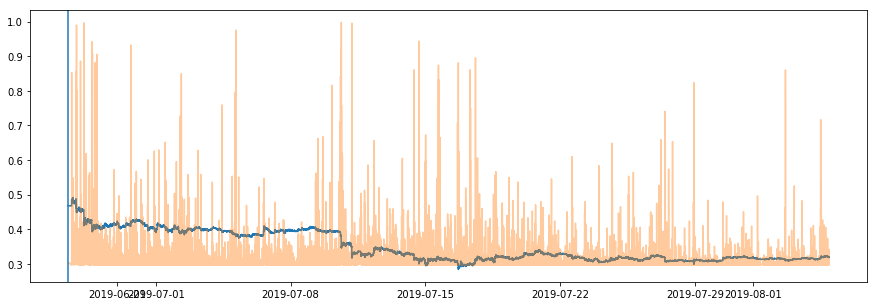

In [135]:
fig, ax = plt.subplots(figsize = (15,5))

ax.plot(percent_action['datetime_real'], percent_action['close_price'])
ax.plot(percent_action['datetime_real'], percent_action['positive_buy_in'], alpha = 0.4)


ax.axvline( x ='2019-06-26 10:46:00', ymin=0, ymax=1)



In [297]:
def plot_around_trend(time_of_action, x_time_before, table):
    
    fig, ax = plt.subplots(figsize = (15,5))
    
    time_to = time_of_action + dt.timedelta(days = x_time_before)
    
    time_from = time_of_action - dt.timedelta(days = x_time_before)
    
    
    to_plot = table[(table['datetime_real'] >= time_from) & (table['datetime_real'] <= time_to)][['datetime_real','close_price']]
    display(to_plot)
#     print(to_plot['close_price'].max())
    
    ax.plot(to_plot['datetime_real'], to_plot['close_price'])
    
    ax.plot(to_plot['datetime_real'], to_plot['close_price'])
    
    ax.axvline( x =time_of_action, ymin=0, ymax=1)
    
    ax.legend()
    plt.show()

actual:  False ;   predicted:  True


,datetime_real,close_price
800536,2019-06-26 14:42:00,0.46783
800537,2019-06-26 14:42:00,0.46783
800538,2019-06-26 14:42:00,0.46783
800539,2019-06-26 14:42:00,0.46783
800540,2019-06-26 14:42:00,0.46783
800541,2019-06-26 14:42:00,0.46783
800542,2019-06-26 14:42:00,0.46783
800543,2019-06-26 14:42:00,0.46783
800544,2019-06-26 14:42:00,0.46783
800545,2019-06-26 14:42:00,0.46783


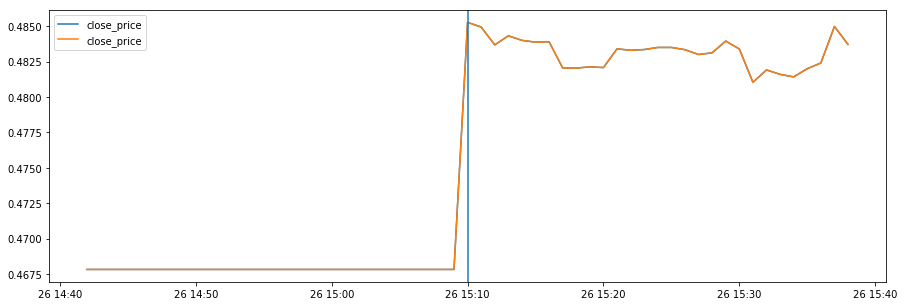

actual:  False ;   predicted:  True


,datetime_real,close_price
802798,2019-06-26 20:12:00,0.47782
802799,2019-06-26 20:13:00,0.47770
802800,2019-06-26 20:14:00,0.47846
802801,2019-06-26 20:15:00,0.47945
802802,2019-06-26 20:16:00,0.47991
802803,2019-06-26 20:17:00,0.48150
802804,2019-06-26 20:18:00,0.47986
802805,2019-06-26 20:19:00,0.48148
802806,2019-06-26 20:20:00,0.48362
802807,2019-06-26 20:21:00,0.48557


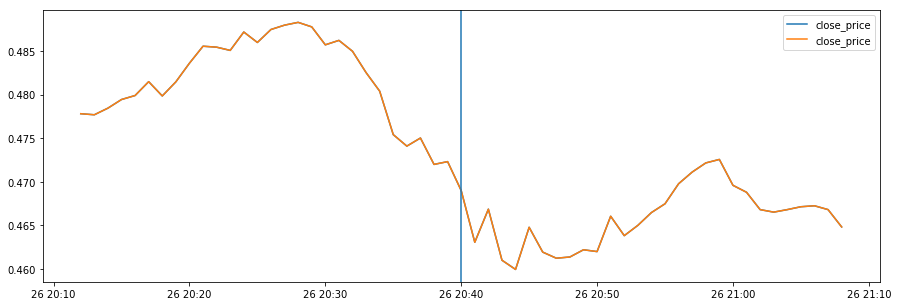

actual:  True ;   predicted:  True


,datetime_real,close_price
802832,2019-06-26 20:46:00,0.46193
802833,2019-06-26 20:47:00,0.46123
802834,2019-06-26 20:48:00,0.46137
802835,2019-06-26 20:49:00,0.46220
802836,2019-06-26 20:50:00,0.46199
802837,2019-06-26 20:51:00,0.46605
802838,2019-06-26 20:52:00,0.46382
802839,2019-06-26 20:53:00,0.46500
802840,2019-06-26 20:54:00,0.46647
802841,2019-06-26 20:55:00,0.46748


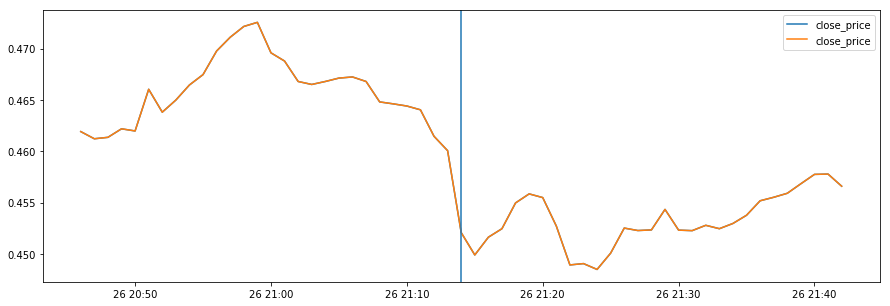

actual:  True ;   predicted:  True


,datetime_real,close_price
802833,2019-06-26 20:47:00,0.46123
802834,2019-06-26 20:48:00,0.46137
802835,2019-06-26 20:49:00,0.46220
802836,2019-06-26 20:50:00,0.46199
802837,2019-06-26 20:51:00,0.46605
802838,2019-06-26 20:52:00,0.46382
802839,2019-06-26 20:53:00,0.46500
802840,2019-06-26 20:54:00,0.46647
802841,2019-06-26 20:55:00,0.46748
802842,2019-06-26 20:56:00,0.46978


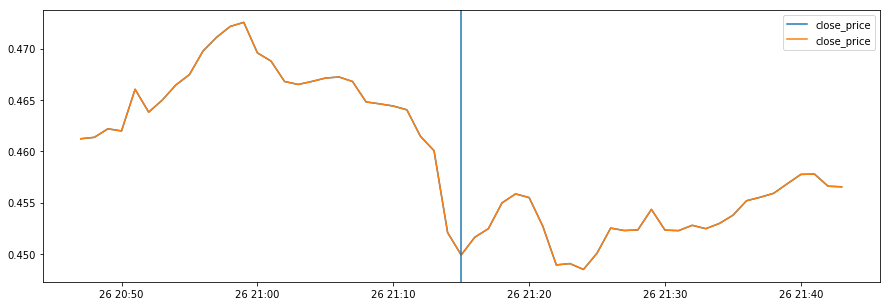

actual:  True ;   predicted:  True


,datetime_real,close_price
803130,2019-06-27 01:44:00,0.45553
803131,2019-06-27 01:45:00,0.45459
803132,2019-06-27 01:46:00,0.45436
803133,2019-06-27 01:47:00,0.45209
803134,2019-06-27 01:48:00,0.45191
803135,2019-06-27 01:49:00,0.45280
803136,2019-06-27 01:50:00,0.45394
803137,2019-06-27 01:51:00,0.45261
803138,2019-06-27 01:52:00,0.45359
803139,2019-06-27 01:53:00,0.45403


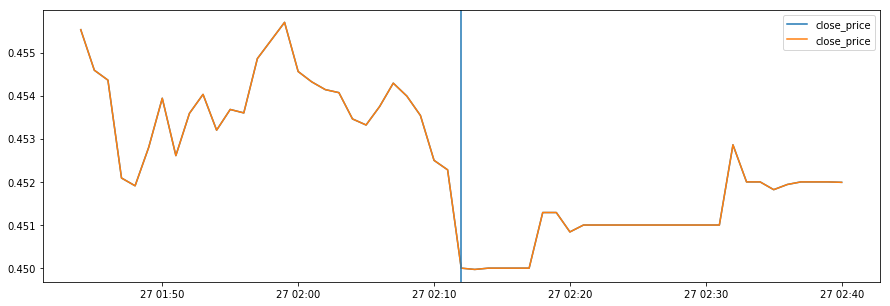

actual:  False ;   predicted:  True


,datetime_real,close_price
803391,2019-06-27 06:01:00,0.45624
803392,2019-06-27 06:02:00,0.45592
803393,2019-06-27 06:03:00,0.45490
803394,2019-06-27 06:04:00,0.45500
803395,2019-06-27 06:05:00,0.45500
803396,2019-06-27 06:06:00,0.45499
803397,2019-06-27 06:07:00,0.45500
803398,2019-06-27 06:08:00,0.45398
803399,2019-06-27 06:09:00,0.45383
803400,2019-06-27 06:10:00,0.45388


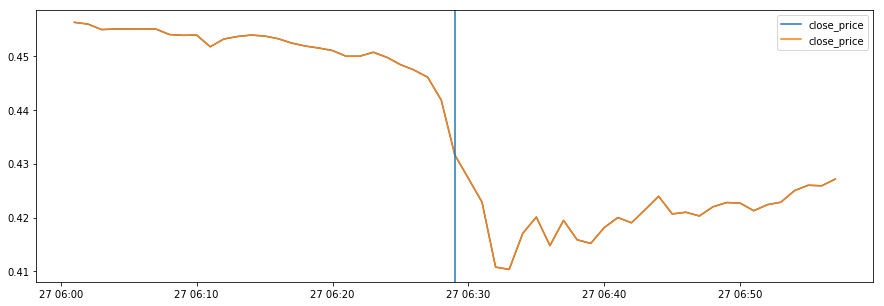

actual:  False ;   predicted:  True


,datetime_real,close_price
803392,2019-06-27 06:02:00,0.45592
803393,2019-06-27 06:03:00,0.45490
803394,2019-06-27 06:04:00,0.45500
803395,2019-06-27 06:05:00,0.45500
803396,2019-06-27 06:06:00,0.45499
803397,2019-06-27 06:07:00,0.45500
803398,2019-06-27 06:08:00,0.45398
803399,2019-06-27 06:09:00,0.45383
803400,2019-06-27 06:10:00,0.45388
803401,2019-06-27 06:11:00,0.45171


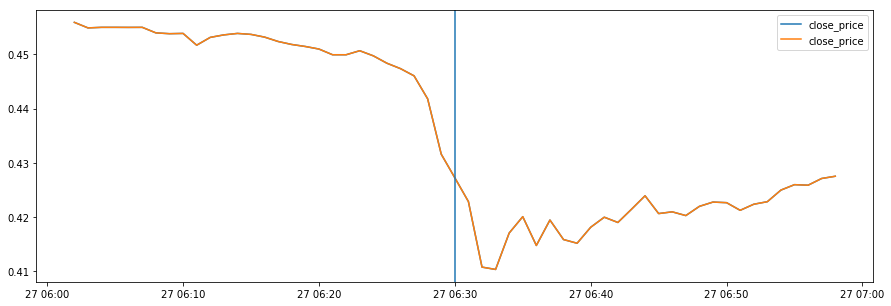

actual:  True ;   predicted:  True


,datetime_real,close_price
803393,2019-06-27 06:03:00,0.45490
803394,2019-06-27 06:04:00,0.45500
803395,2019-06-27 06:05:00,0.45500
803396,2019-06-27 06:06:00,0.45499
803397,2019-06-27 06:07:00,0.45500
803398,2019-06-27 06:08:00,0.45398
803399,2019-06-27 06:09:00,0.45383
803400,2019-06-27 06:10:00,0.45388
803401,2019-06-27 06:11:00,0.45171
803402,2019-06-27 06:12:00,0.45315


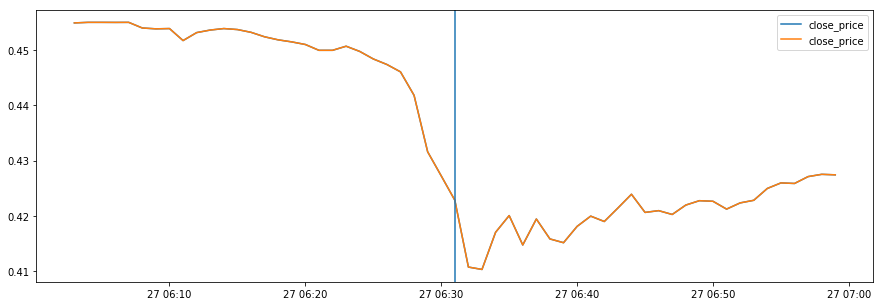

actual:  True ;   predicted:  True


,datetime_real,close_price
803394,2019-06-27 06:04:00,0.45500
803395,2019-06-27 06:05:00,0.45500
803396,2019-06-27 06:06:00,0.45499
803397,2019-06-27 06:07:00,0.45500
803398,2019-06-27 06:08:00,0.45398
803399,2019-06-27 06:09:00,0.45383
803400,2019-06-27 06:10:00,0.45388
803401,2019-06-27 06:11:00,0.45171
803402,2019-06-27 06:12:00,0.45315
803403,2019-06-27 06:13:00,0.45361


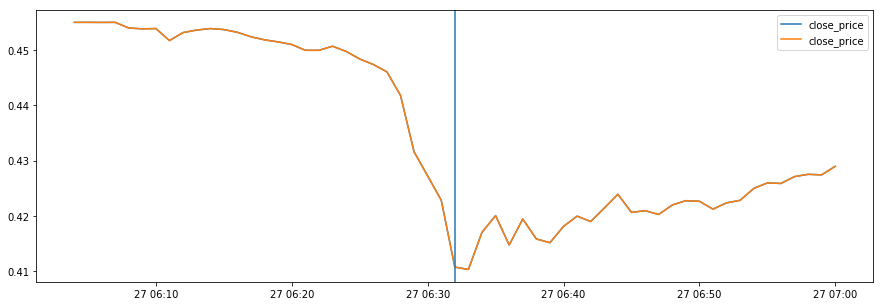

actual:  True ;   predicted:  True


,datetime_real,close_price
803395,2019-06-27 06:05:00,0.45500
803396,2019-06-27 06:06:00,0.45499
803397,2019-06-27 06:07:00,0.45500
803398,2019-06-27 06:08:00,0.45398
803399,2019-06-27 06:09:00,0.45383
803400,2019-06-27 06:10:00,0.45388
803401,2019-06-27 06:11:00,0.45171
803402,2019-06-27 06:12:00,0.45315
803403,2019-06-27 06:13:00,0.45361
803404,2019-06-27 06:14:00,0.45388


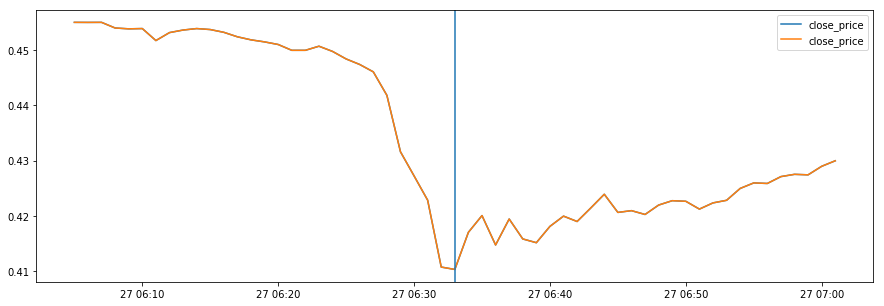

actual:  True ;   predicted:  True


,datetime_real,close_price
803396,2019-06-27 06:06:00,0.45499
803397,2019-06-27 06:07:00,0.45500
803398,2019-06-27 06:08:00,0.45398
803399,2019-06-27 06:09:00,0.45383
803400,2019-06-27 06:10:00,0.45388
803401,2019-06-27 06:11:00,0.45171
803402,2019-06-27 06:12:00,0.45315
803403,2019-06-27 06:13:00,0.45361
803404,2019-06-27 06:14:00,0.45388
803405,2019-06-27 06:15:00,0.45370


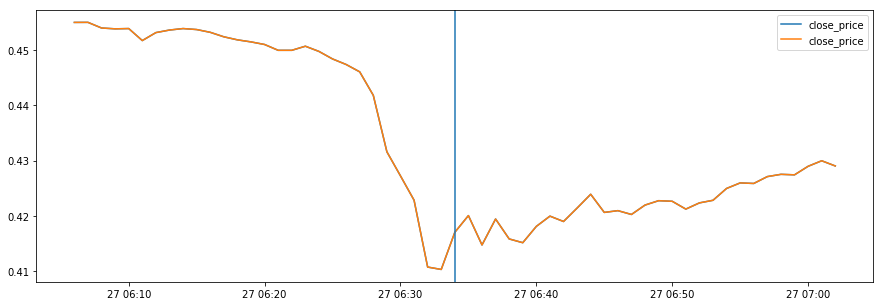

actual:  True ;   predicted:  True


,datetime_real,close_price
803987,2019-06-27 15:53:00,0.42482
803988,2019-06-27 15:54:00,0.42560
803989,2019-06-27 15:55:00,0.42591
803990,2019-06-27 15:56:00,0.42665
803991,2019-06-27 15:57:00,0.42641
803992,2019-06-27 15:58:00,0.42600
803993,2019-06-27 15:59:00,0.42606
803994,2019-06-27 16:00:00,0.42674
803995,2019-06-27 16:01:00,0.42648
803996,2019-06-27 16:02:00,0.42726


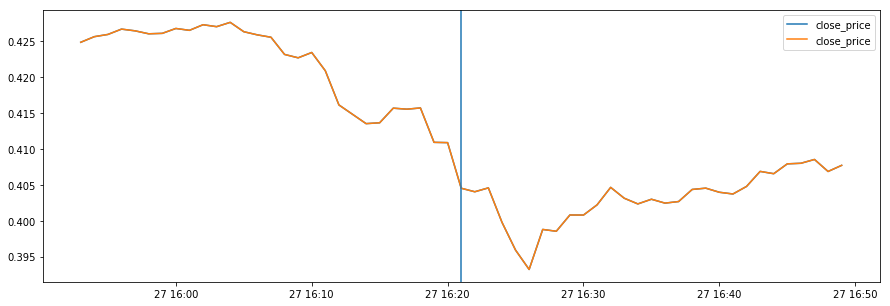

actual:  True ;   predicted:  True


,datetime_real,close_price
804032,2019-06-27 16:38:00,0.40436
804033,2019-06-27 16:39:00,0.40454
804034,2019-06-27 16:40:00,0.40397
804035,2019-06-27 16:41:00,0.40373
804036,2019-06-27 16:42:00,0.40478
804037,2019-06-27 16:43:00,0.40687
804038,2019-06-27 16:44:00,0.40655
804039,2019-06-27 16:45:00,0.40792
804040,2019-06-27 16:46:00,0.40800
804041,2019-06-27 16:47:00,0.40853


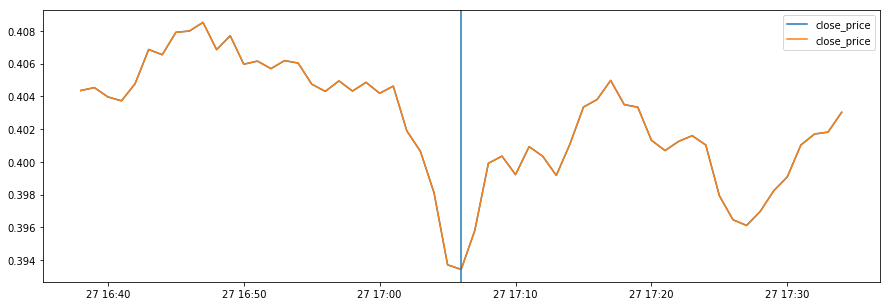

actual:  True ;   predicted:  True


,datetime_real,close_price
804239,2019-06-27 20:05:00,0.40788
804240,2019-06-27 20:06:00,0.40661
804241,2019-06-27 20:07:00,0.40425
804242,2019-06-27 20:08:00,0.40468
804243,2019-06-27 20:09:00,0.40335
804244,2019-06-27 20:10:00,0.40335
804245,2019-06-27 20:11:00,0.40496
804246,2019-06-27 20:12:00,0.40410
804247,2019-06-27 20:13:00,0.40335
804248,2019-06-27 20:14:00,0.40371


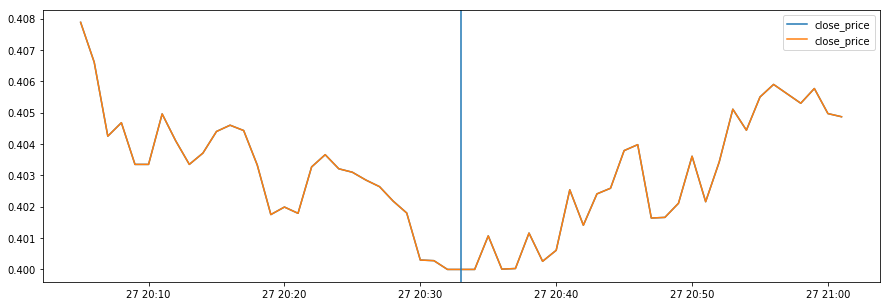

actual:  False ;   predicted:  True


,datetime_real,close_price
804356,2019-06-27 22:00:00,0.41135
804357,2019-06-27 22:01:00,0.41313
804358,2019-06-27 22:02:00,0.41092
804359,2019-06-27 22:03:00,0.41250
804360,2019-06-27 22:04:00,0.41293
804361,2019-06-27 22:05:00,0.41356
804362,2019-06-27 22:06:00,0.41380
804363,2019-06-27 22:07:00,0.41336
804364,2019-06-27 22:08:00,0.41326
804365,2019-06-27 22:09:00,0.41276


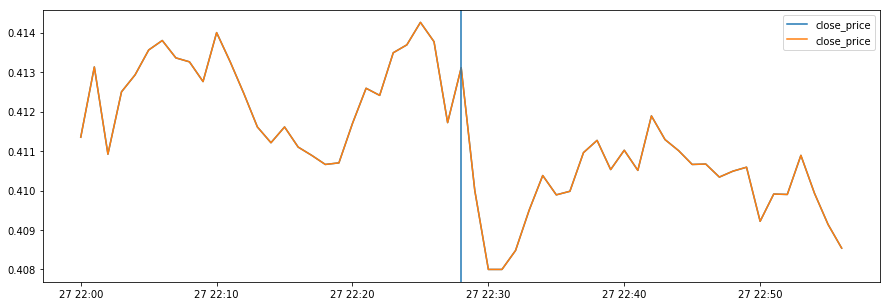

actual:  False ;   predicted:  True


,datetime_real,close_price
807103,2019-06-29 16:53:00,0.42032
807104,2019-06-29 16:54:00,0.42088
807105,2019-06-29 16:55:00,0.42247
807106,2019-06-29 16:56:00,0.42056
807107,2019-06-29 16:57:00,0.42071
807108,2019-06-29 16:58:00,0.41951
807109,2019-06-29 16:59:00,0.42120
807110,2019-06-29 17:00:00,0.42041
807111,2019-06-29 17:01:00,0.41952
807112,2019-06-29 17:02:00,0.41972


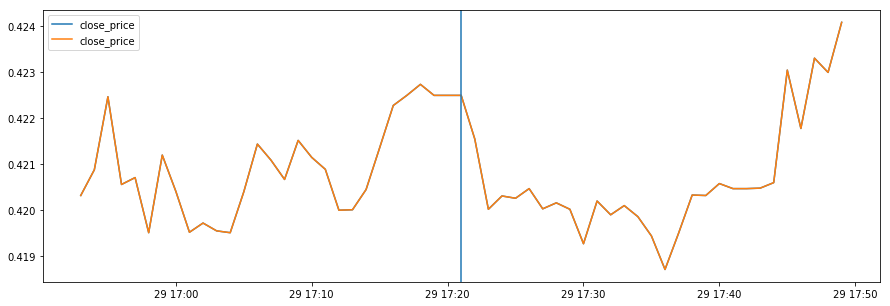

actual:  False ;   predicted:  True


,datetime_real,close_price
807104,2019-06-29 16:54:00,0.42088
807105,2019-06-29 16:55:00,0.42247
807106,2019-06-29 16:56:00,0.42056
807107,2019-06-29 16:57:00,0.42071
807108,2019-06-29 16:58:00,0.41951
807109,2019-06-29 16:59:00,0.42120
807110,2019-06-29 17:00:00,0.42041
807111,2019-06-29 17:01:00,0.41952
807112,2019-06-29 17:02:00,0.41972
807113,2019-06-29 17:03:00,0.41955


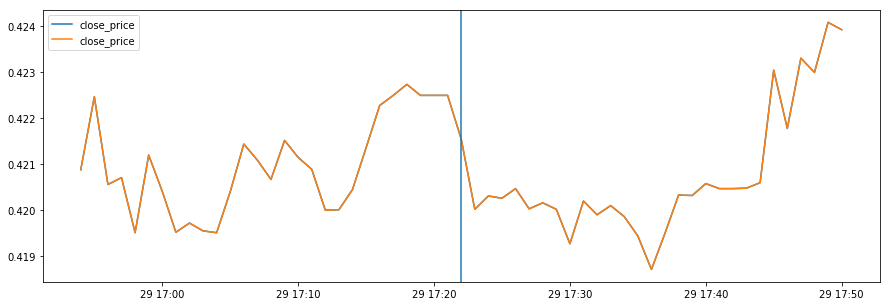

actual:  True ;   predicted:  True


,datetime_real,close_price
811185,2019-07-02 07:23:00,0.39276
811186,2019-07-02 07:24:00,0.39277
811187,2019-07-02 07:25:00,0.39216
811188,2019-07-02 07:25:00,0.39216
811189,2019-07-02 07:26:00,0.39216
811190,2019-07-02 07:26:00,0.39216
811191,2019-07-02 07:27:00,0.39215
811192,2019-07-02 07:27:00,0.39215
811193,2019-07-02 07:28:00,0.39215
811194,2019-07-02 07:28:00,0.39215


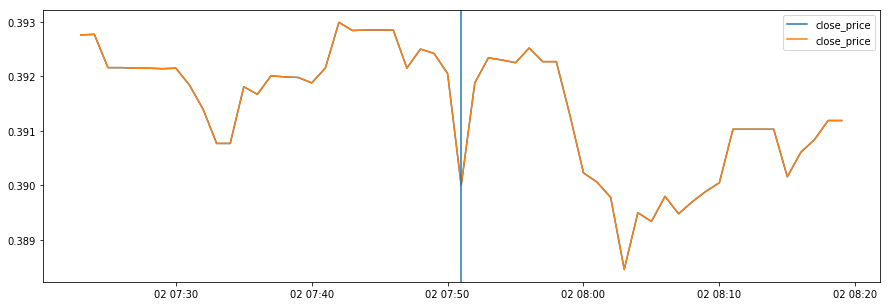

actual:  True ;   predicted:  True


,datetime_real,close_price
816467,2019-07-05 03:39:00,0.38463
816468,2019-07-05 03:40:00,0.38464
816469,2019-07-05 03:41:00,0.38461
816470,2019-07-05 03:41:00,0.38461
816471,2019-07-05 03:42:00,0.38461
816472,2019-07-05 03:42:00,0.38461
816473,2019-07-05 03:43:00,0.38470
816474,2019-07-05 03:44:00,0.38479
816475,2019-07-05 03:44:00,0.38479
816476,2019-07-05 03:45:00,0.38479


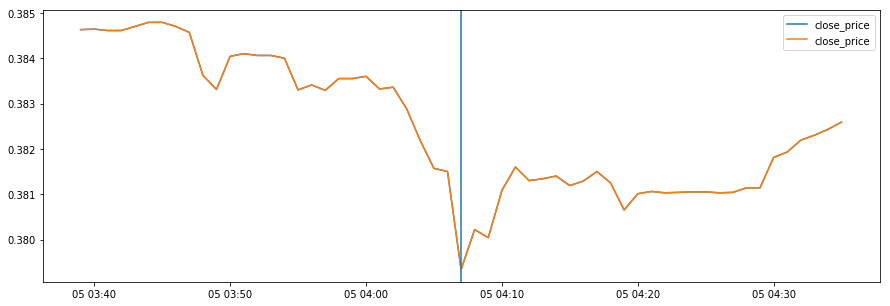

actual:  True ;   predicted:  True


,datetime_real,close_price
826445,2019-07-10 13:47:00,0.39225
826446,2019-07-10 13:48:00,0.39198
826447,2019-07-10 13:49:00,0.39165
826448,2019-07-10 13:50:00,0.39170
826449,2019-07-10 13:51:00,0.39199
826450,2019-07-10 13:52:00,0.39126
826451,2019-07-10 13:53:00,0.39131
826452,2019-07-10 13:54:00,0.39160
826453,2019-07-10 13:55:00,0.39151
826454,2019-07-10 13:56:00,0.39173


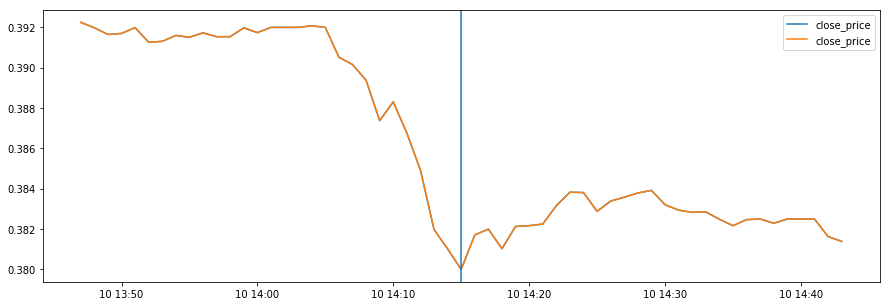

actual:  True ;   predicted:  True


,datetime_real,close_price
826492,2019-07-10 14:34:00,0.38249
826493,2019-07-10 14:35:00,0.38217
826494,2019-07-10 14:36:00,0.38247
826495,2019-07-10 14:37:00,0.38250
826496,2019-07-10 14:38:00,0.38229
826497,2019-07-10 14:39:00,0.38250
826498,2019-07-10 14:40:00,0.38250
826499,2019-07-10 14:41:00,0.38250
826500,2019-07-10 14:42:00,0.38163
826501,2019-07-10 14:43:00,0.38139


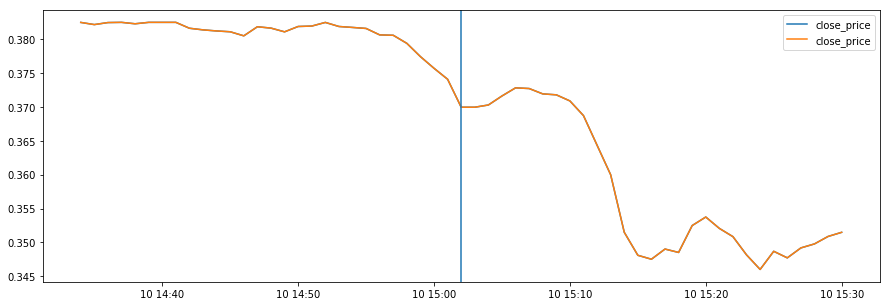

actual:  False ;   predicted:  True


,datetime_real,close_price
826503,2019-07-10 14:45:00,0.38111
826504,2019-07-10 14:46:00,0.38051
826505,2019-07-10 14:47:00,0.38185
826506,2019-07-10 14:48:00,0.38165
826507,2019-07-10 14:49:00,0.38110
826508,2019-07-10 14:50:00,0.38189
826509,2019-07-10 14:51:00,0.38195
826510,2019-07-10 14:52:00,0.38249
826511,2019-07-10 14:53:00,0.38189
826512,2019-07-10 14:54:00,0.38175


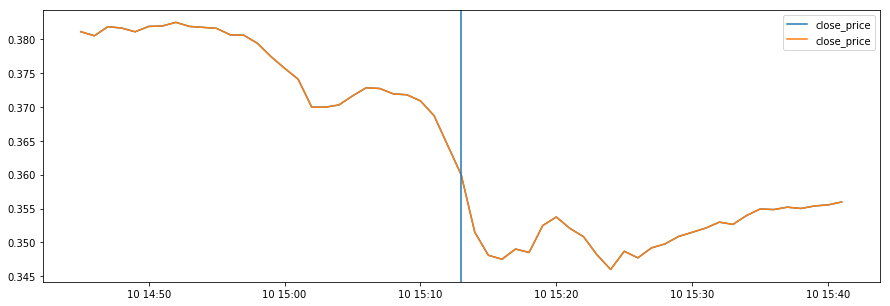

actual:  True ;   predicted:  True


,datetime_real,close_price
826504,2019-07-10 14:46:00,0.38051
826505,2019-07-10 14:47:00,0.38185
826506,2019-07-10 14:48:00,0.38165
826507,2019-07-10 14:49:00,0.38110
826508,2019-07-10 14:50:00,0.38189
826509,2019-07-10 14:51:00,0.38195
826510,2019-07-10 14:52:00,0.38249
826511,2019-07-10 14:53:00,0.38189
826512,2019-07-10 14:54:00,0.38175
826513,2019-07-10 14:55:00,0.38160


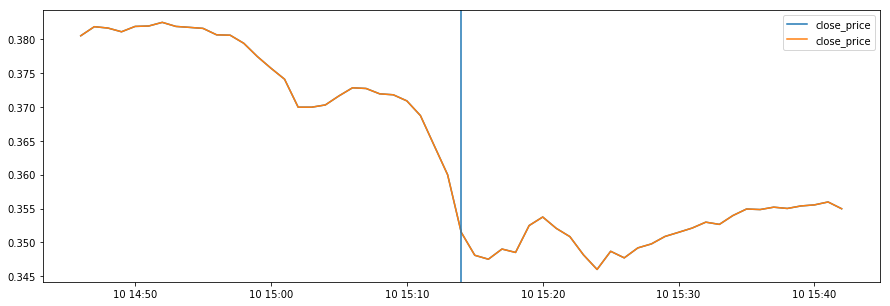

actual:  True ;   predicted:  True


,datetime_real,close_price
826506,2019-07-10 14:48:00,0.38165
826507,2019-07-10 14:49:00,0.38110
826508,2019-07-10 14:50:00,0.38189
826509,2019-07-10 14:51:00,0.38195
826510,2019-07-10 14:52:00,0.38249
826511,2019-07-10 14:53:00,0.38189
826512,2019-07-10 14:54:00,0.38175
826513,2019-07-10 14:55:00,0.38160
826514,2019-07-10 14:56:00,0.38065
826515,2019-07-10 14:57:00,0.38059


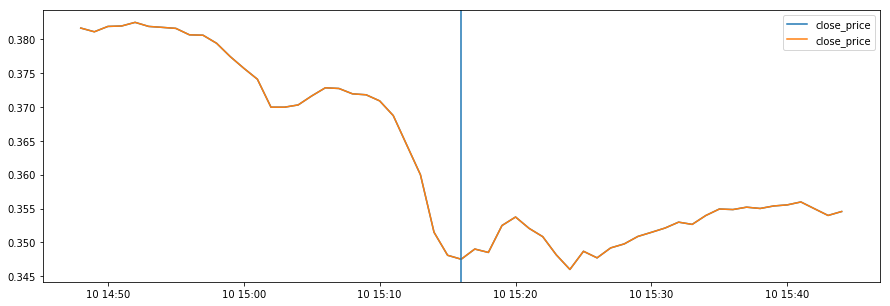

actual:  True ;   predicted:  True


,datetime_real,close_price
826507,2019-07-10 14:49:00,0.38110
826508,2019-07-10 14:50:00,0.38189
826509,2019-07-10 14:51:00,0.38195
826510,2019-07-10 14:52:00,0.38249
826511,2019-07-10 14:53:00,0.38189
826512,2019-07-10 14:54:00,0.38175
826513,2019-07-10 14:55:00,0.38160
826514,2019-07-10 14:56:00,0.38065
826515,2019-07-10 14:57:00,0.38059
826516,2019-07-10 14:58:00,0.37940


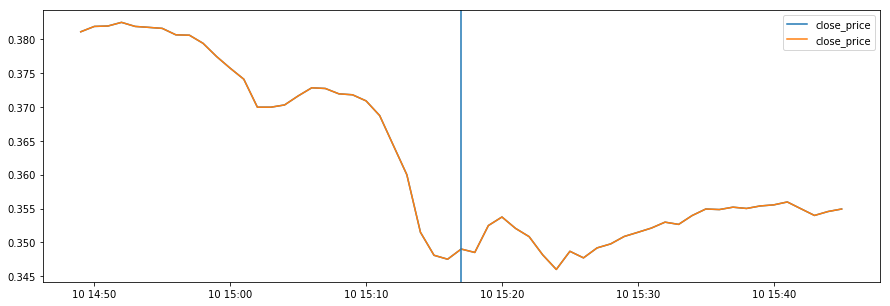

actual:  True ;   predicted:  True


,datetime_real,close_price
827401,2019-07-11 03:49:00,0.35107
827402,2019-07-11 03:50:00,0.35073
827403,2019-07-11 03:51:00,0.35017
827404,2019-07-11 03:52:00,0.35038
827405,2019-07-11 03:53:00,0.35001
827406,2019-07-11 03:54:00,0.35041
827407,2019-07-11 03:55:00,0.35075
827408,2019-07-11 03:56:00,0.35091
827409,2019-07-11 03:57:00,0.35105
827410,2019-07-11 03:58:00,0.35068


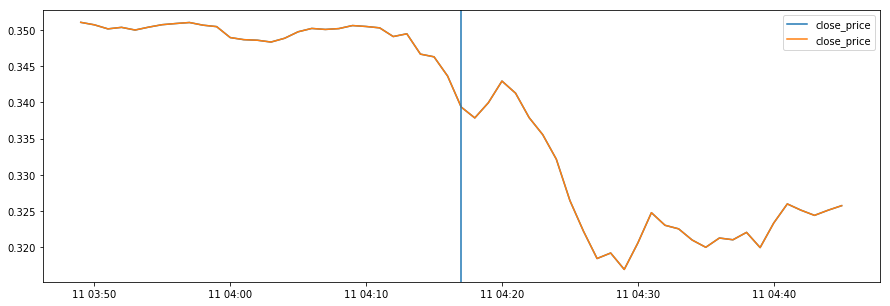

actual:  False ;   predicted:  True


,datetime_real,close_price
827408,2019-07-11 03:56:00,0.35091
827409,2019-07-11 03:57:00,0.35105
827410,2019-07-11 03:58:00,0.35068
827411,2019-07-11 03:59:00,0.35048
827412,2019-07-11 04:00:00,0.34897
827413,2019-07-11 04:01:00,0.34868
827414,2019-07-11 04:02:00,0.34860
827415,2019-07-11 04:03:00,0.34835
827416,2019-07-11 04:04:00,0.34887
827417,2019-07-11 04:05:00,0.34977


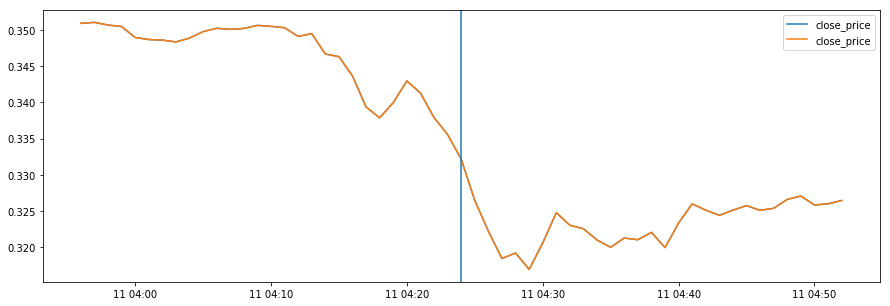

actual:  True ;   predicted:  True


,datetime_real,close_price
827411,2019-07-11 03:59:00,0.35048
827412,2019-07-11 04:00:00,0.34897
827413,2019-07-11 04:01:00,0.34868
827414,2019-07-11 04:02:00,0.34860
827415,2019-07-11 04:03:00,0.34835
827416,2019-07-11 04:04:00,0.34887
827417,2019-07-11 04:05:00,0.34977
827418,2019-07-11 04:06:00,0.35023
827419,2019-07-11 04:07:00,0.35009
827420,2019-07-11 04:08:00,0.35021


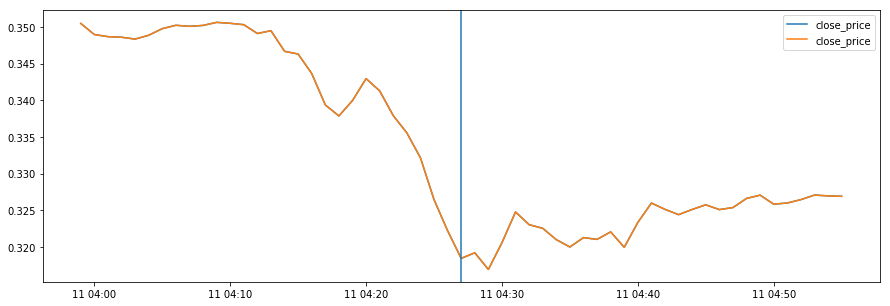

actual:  True ;   predicted:  True


,datetime_real,close_price
861842,2019-07-14 09:26:00,0.32682
861843,2019-07-14 09:27:00,0.32759
861844,2019-07-14 09:27:00,0.32759
861845,2019-07-14 09:28:00,0.32759
861846,2019-07-14 09:28:00,0.32759
861847,2019-07-14 09:29:00,0.32748
861848,2019-07-14 09:30:00,0.32770
861849,2019-07-14 09:31:00,0.32734
861850,2019-07-14 09:32:00,0.32778
861851,2019-07-14 09:33:00,0.32760


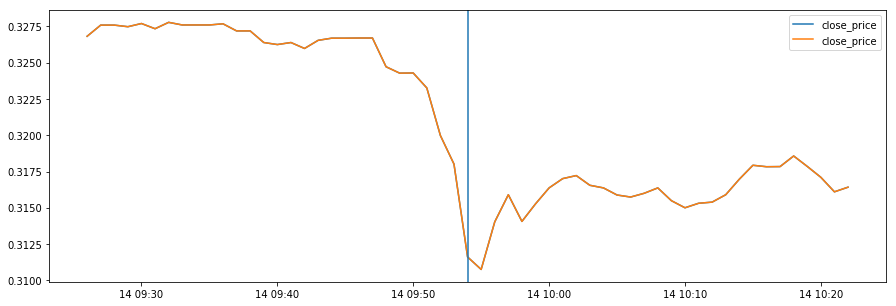

actual:  True ;   predicted:  True


,datetime_real,close_price
861843,2019-07-14 09:27:00,0.32759
861844,2019-07-14 09:27:00,0.32759
861845,2019-07-14 09:28:00,0.32759
861846,2019-07-14 09:28:00,0.32759
861847,2019-07-14 09:29:00,0.32748
861848,2019-07-14 09:30:00,0.32770
861849,2019-07-14 09:31:00,0.32734
861850,2019-07-14 09:32:00,0.32778
861851,2019-07-14 09:33:00,0.32760
861852,2019-07-14 09:33:00,0.32760


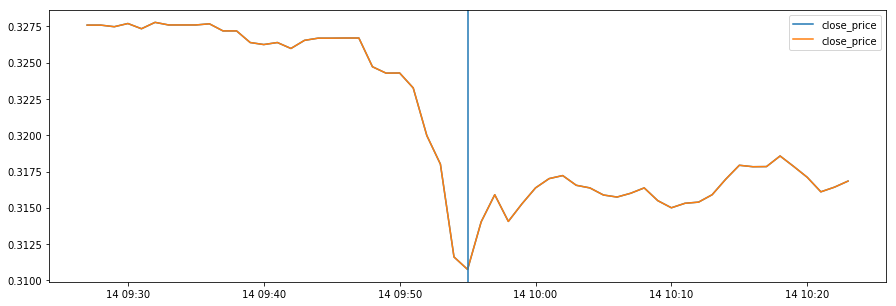

actual:  True ;   predicted:  True


,datetime_real,close_price
862210,2019-07-14 15:20:00,0.31145
862211,2019-07-14 15:21:00,0.31153
862212,2019-07-14 15:22:00,0.31139
862213,2019-07-14 15:23:00,0.31283
862214,2019-07-14 15:24:00,0.31253
862215,2019-07-14 15:25:00,0.31312
862216,2019-07-14 15:26:00,0.31289
862217,2019-07-14 15:27:00,0.31256
862218,2019-07-14 15:28:00,0.31202
862219,2019-07-14 15:29:00,0.31217


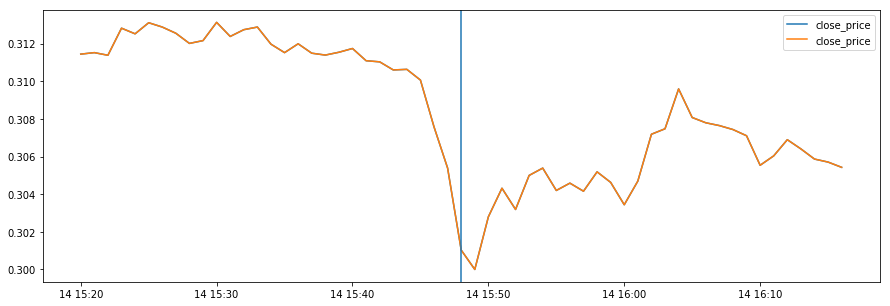

actual:  True ;   predicted:  True


,datetime_real,close_price
862211,2019-07-14 15:21:00,0.31153
862212,2019-07-14 15:22:00,0.31139
862213,2019-07-14 15:23:00,0.31283
862214,2019-07-14 15:24:00,0.31253
862215,2019-07-14 15:25:00,0.31312
862216,2019-07-14 15:26:00,0.31289
862217,2019-07-14 15:27:00,0.31256
862218,2019-07-14 15:28:00,0.31202
862219,2019-07-14 15:29:00,0.31217
862220,2019-07-14 15:30:00,0.31314


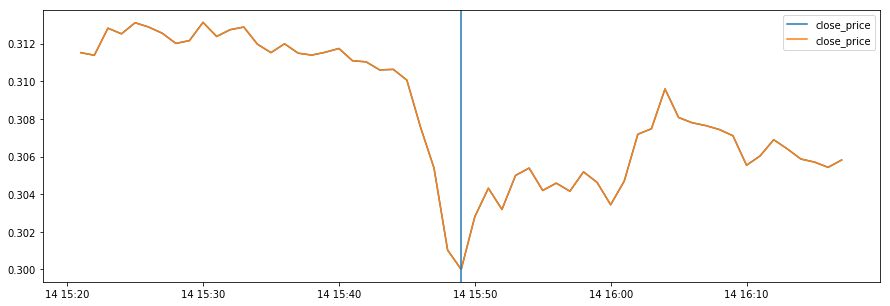

actual:  True ;   predicted:  True


,datetime_real,close_price
863784,2019-07-15 15:48:00,0.31842
863785,2019-07-15 15:49:00,0.31889
863786,2019-07-15 15:50:00,0.31900
863787,2019-07-15 15:51:00,0.31900
863788,2019-07-15 15:52:00,0.31860
863789,2019-07-15 15:53:00,0.31867
863790,2019-07-15 15:54:00,0.31869
863791,2019-07-15 15:55:00,0.31874
863792,2019-07-15 15:56:00,0.31860
863793,2019-07-15 15:57:00,0.31913


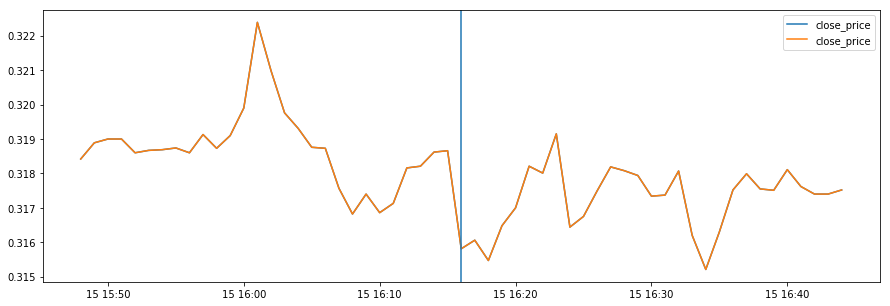

actual:  True ;   predicted:  True


,datetime_real,close_price
863793,2019-07-15 15:57:00,0.31913
863794,2019-07-15 15:58:00,0.31873
863795,2019-07-15 15:59:00,0.31910
863796,2019-07-15 16:00:00,0.31990
863797,2019-07-15 16:01:00,0.32239
863798,2019-07-15 16:02:00,0.32099
863799,2019-07-15 16:03:00,0.31976
863800,2019-07-15 16:04:00,0.31931
863801,2019-07-15 16:05:00,0.31876
863802,2019-07-15 16:06:00,0.31873


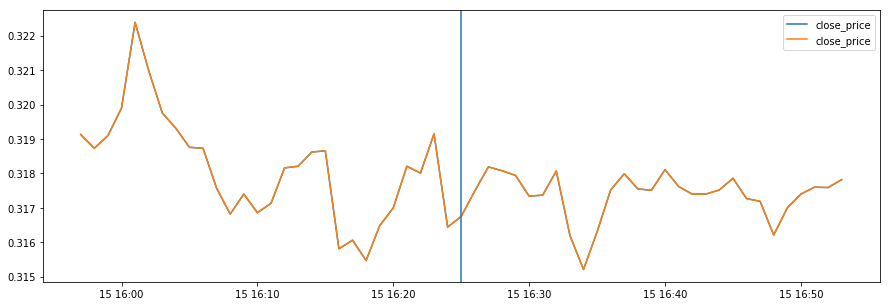

actual:  True ;   predicted:  True


,datetime_real,close_price
865642,2019-07-16 16:34:00,0.29900
865643,2019-07-16 16:35:00,0.29800
865644,2019-07-16 16:36:00,0.29863
865645,2019-07-16 16:37:00,0.29864
865646,2019-07-16 16:38:00,0.29982
865647,2019-07-16 16:39:00,0.29951
865648,2019-07-16 16:40:00,0.29847
865649,2019-07-16 16:41:00,0.29850
865650,2019-07-16 16:42:00,0.29859
865651,2019-07-16 16:43:00,0.29888


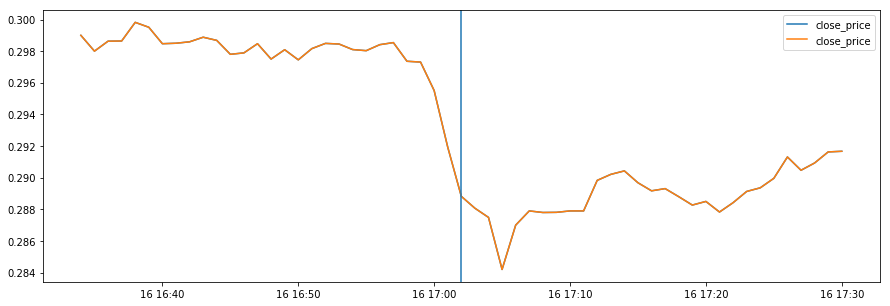

actual:  True ;   predicted:  True


,datetime_real,close_price
866577,2019-07-17 07:15:00,0.29990
866578,2019-07-17 07:16:00,0.30035
866579,2019-07-17 07:17:00,0.30027
866580,2019-07-17 07:18:00,0.29990
866581,2019-07-17 07:19:00,0.29958
866582,2019-07-17 07:20:00,0.29938
866583,2019-07-17 07:20:00,0.29938
866584,2019-07-17 07:21:00,0.29938
866585,2019-07-17 07:21:00,0.29938
866586,2019-07-17 07:22:00,0.30008


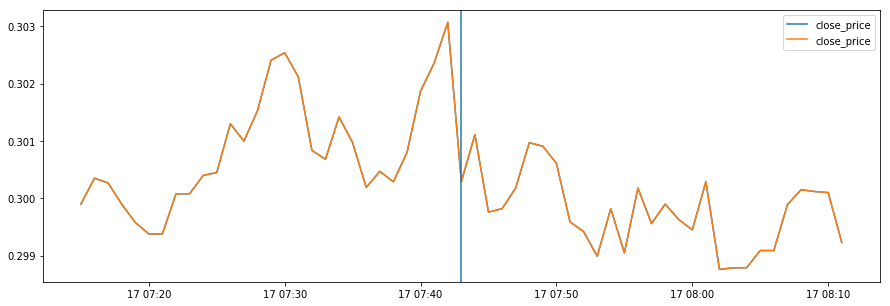

actual:  True ;   predicted:  True


,datetime_real,close_price
866579,2019-07-17 07:17:00,0.30027
866580,2019-07-17 07:18:00,0.29990
866581,2019-07-17 07:19:00,0.29958
866582,2019-07-17 07:20:00,0.29938
866583,2019-07-17 07:20:00,0.29938
866584,2019-07-17 07:21:00,0.29938
866585,2019-07-17 07:21:00,0.29938
866586,2019-07-17 07:22:00,0.30008
866587,2019-07-17 07:22:00,0.30008
866588,2019-07-17 07:23:00,0.30008


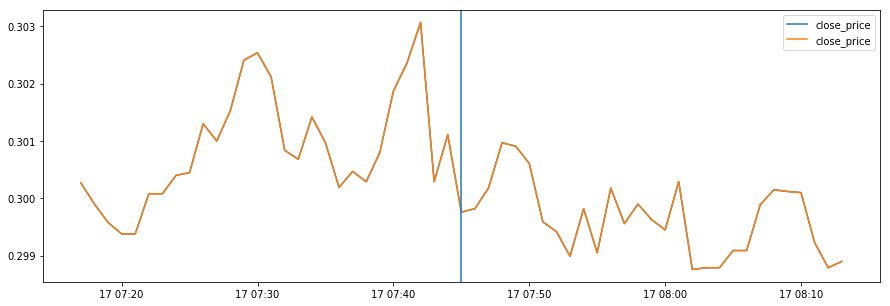

actual:  True ;   predicted:  True


,datetime_real,close_price
867053,2019-07-17 13:55:00,0.30987
867054,2019-07-17 13:56:00,0.30822
867055,2019-07-17 13:57:00,0.30891
867056,2019-07-17 13:58:00,0.30882
867057,2019-07-17 13:59:00,0.30929
867058,2019-07-17 14:00:00,0.30910
867059,2019-07-17 14:01:00,0.31150
867060,2019-07-17 14:02:00,0.31260
867061,2019-07-17 14:03:00,0.31445
867062,2019-07-17 14:04:00,0.31348


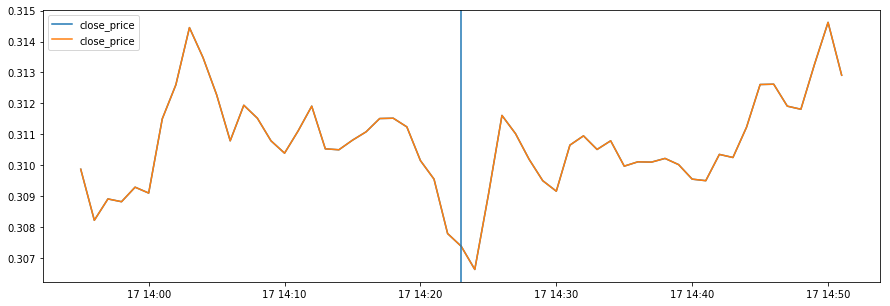

actual:  True ;   predicted:  True


,datetime_real,close_price
867054,2019-07-17 13:56:00,0.30822
867055,2019-07-17 13:57:00,0.30891
867056,2019-07-17 13:58:00,0.30882
867057,2019-07-17 13:59:00,0.30929
867058,2019-07-17 14:00:00,0.30910
867059,2019-07-17 14:01:00,0.31150
867060,2019-07-17 14:02:00,0.31260
867061,2019-07-17 14:03:00,0.31445
867062,2019-07-17 14:04:00,0.31348
867063,2019-07-17 14:05:00,0.31228


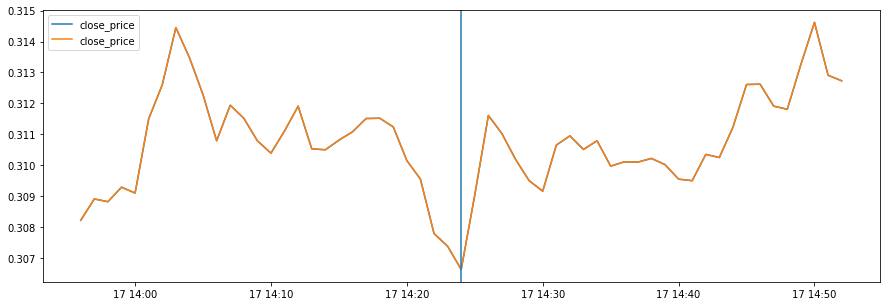

actual:  True ;   predicted:  True


,datetime_real,close_price
888117,2019-07-28 22:01:00,0.30600
888118,2019-07-28 22:02:00,0.30505
888119,2019-07-28 22:03:00,0.30529
888120,2019-07-28 22:04:00,0.30531
888121,2019-07-28 22:05:00,0.30497
888122,2019-07-28 22:06:00,0.30530
888123,2019-07-28 22:07:00,0.30554
888124,2019-07-28 22:08:00,0.30561
888125,2019-07-28 22:09:00,0.30570
888126,2019-07-28 22:10:00,0.30559


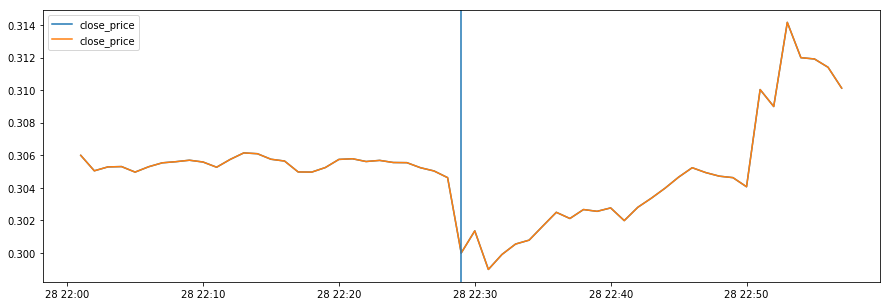

actual:  True ;   predicted:  True


,datetime_real,close_price
934413,2019-08-02 16:13:00,0.31366
934414,2019-08-02 16:14:00,0.31380
934415,2019-08-02 16:15:00,0.31362
934416,2019-08-02 16:16:00,0.31359
934417,2019-08-02 16:17:00,0.31337
934418,2019-08-02 16:18:00,0.31355
934419,2019-08-02 16:19:00,0.31101
934420,2019-08-02 16:20:00,0.31038
934421,2019-08-02 16:21:00,0.31216
934422,2019-08-02 16:22:00,0.31139


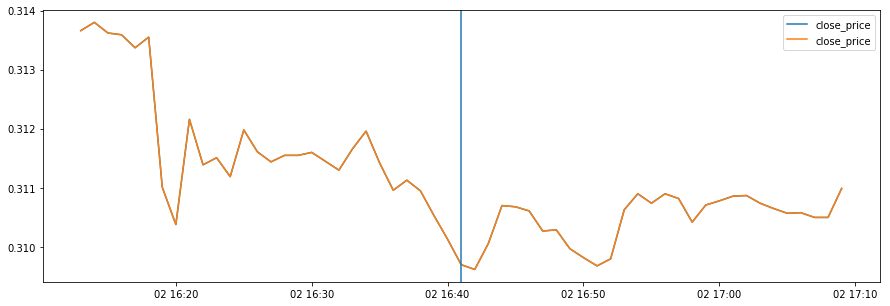

In [298]:
for k, v in percent_action[percent_action['positive_buy_in'] > 0.8].iterrows():
    print('actual: ' , v['actual'] ,  ';   predicted: ', v['predict'])
    plot_around_trend(v['datetime_real'], 0.02 , within_target_02_profit)
    break

## XG Boost

In [310]:
#X, y = data.iloc[:,:-1],data.iloc[:,-1]

In [311]:
# X, y = within_target_02_profit[properties].copy(), within_target_02_profit['Buy_In'].copy()
# X, y = within_target_02_profit[iterate_1_features].copy(), within_target_02_profit['Buy_In'].copy()
# X, y = within_target_02_profit[iterate_2_features].copy(), within_target_02_profit['Buy_In'].copy()
X, y = within_target_02_profit[key_features_selection_2].copy(), within_target_02_profit['Buy_In'].copy()


In [312]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [313]:
X_train_order = X.iloc[:-math.floor(len(X)*0.2)]

In [314]:
y_train_order = y.iloc[:-math.floor(len(y)*0.2)]

In [315]:
X_test_order = X.iloc[-math.floor(len(X)*0.2):]

In [316]:
y_test_order = y.iloc[-math.floor(len(y)*0.2):]

In [317]:
# plot decision tree
# from numpy import loadtxt
# from xgboost import XGBClassifier
from xgboost import plot_tree

# load data
# dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
# X = dataset[:,0:8]
# y = dataset[:,8]
# # fit model no training data
# model = XGBClassifier()
# model.fit(X, y)
# plot single tree


In [318]:
xg_reg = xgb.XGBClassifier().fit(X = X_train_order, y = y_train_order ) #reg:logistic for tree


In [319]:
y_pred = xg_reg.predict(X_test_order)

In [320]:
xg_reg.predict_proba(X_test_order)

array([[0.76398563, 0.2360144 ],
       [0.76398563, 0.2360144 ],
       [0.76398563, 0.2360144 ],
       ...,
       [0.647549  , 0.35245103],
       [0.6329962 , 0.36700383],
       [0.6204821 , 0.3795179 ]], dtype=float32)

In [321]:
predict_prob = xg_reg.predict_proba(X_test_order)

In [322]:
accuracy = accuracy_score(y_true = y_test_order, y_pred = y_pred)

In [351]:
print(accuracy)  #0.6557448975170083

0.713540538198206


In [352]:
confusion_matrix(y_test_order, y_pred,  labels = [True, False])

array([[   189,  48881],
       [    58, 135488]], dtype=int64)

In [346]:
# plot_tree(xg_reg)

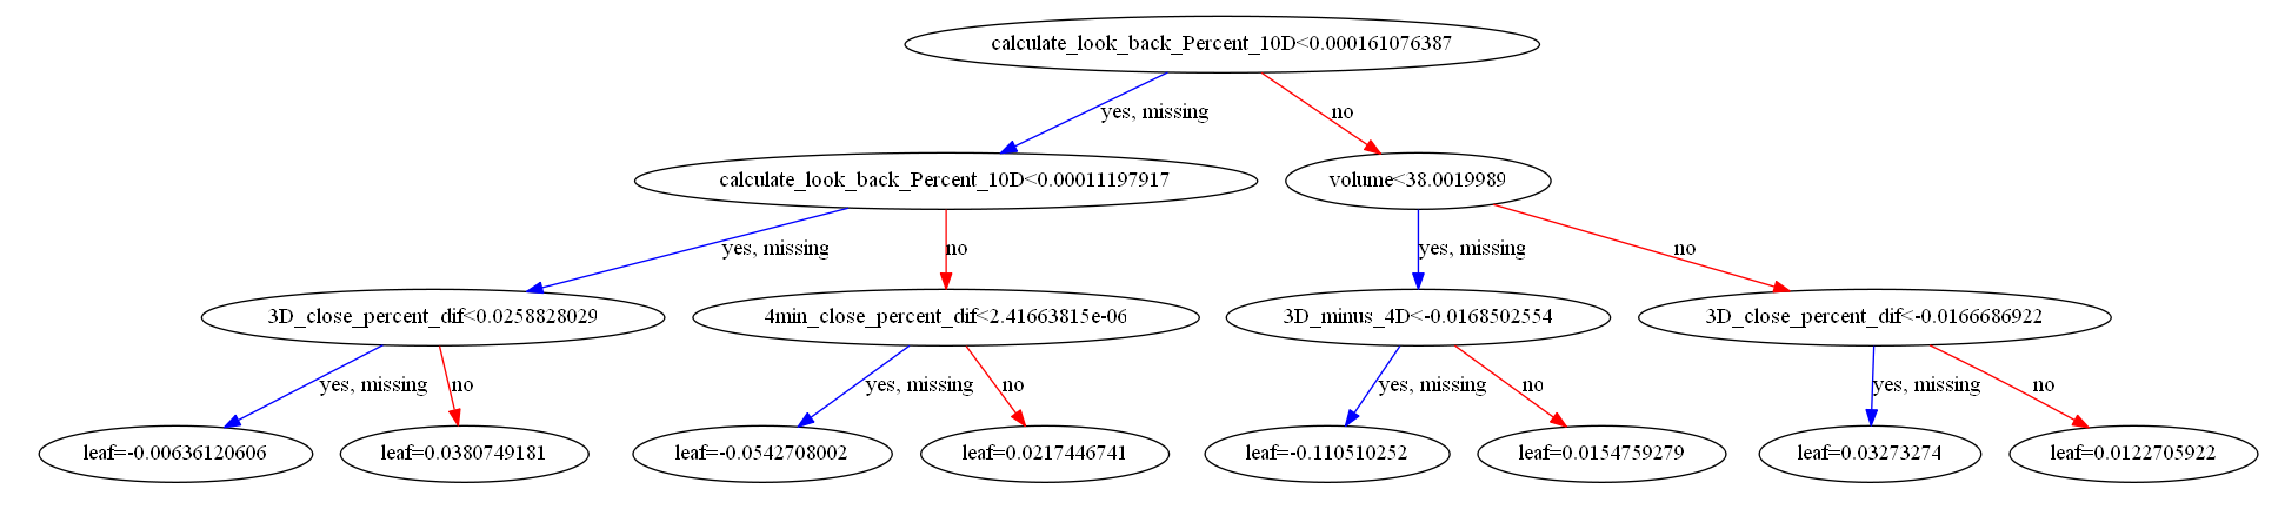

In [347]:
fig, ax = plt.subplots(figsize=(40, 60))
xgb.plot_tree(xg_reg, num_trees=30, ax=ax)
plt.show()

In [349]:
X_train_order.columns

Index(['volume', '4min_close_percent_dif', '1H_close_percent_dif',
       '12H_close_percent_dif', '3D_close_percent_dif',
       'calculate_look_back_Percent_10D', '4min_minus_10min', '1H_minus_2H',
       '3D_minus_4D'],
      dtype='object')

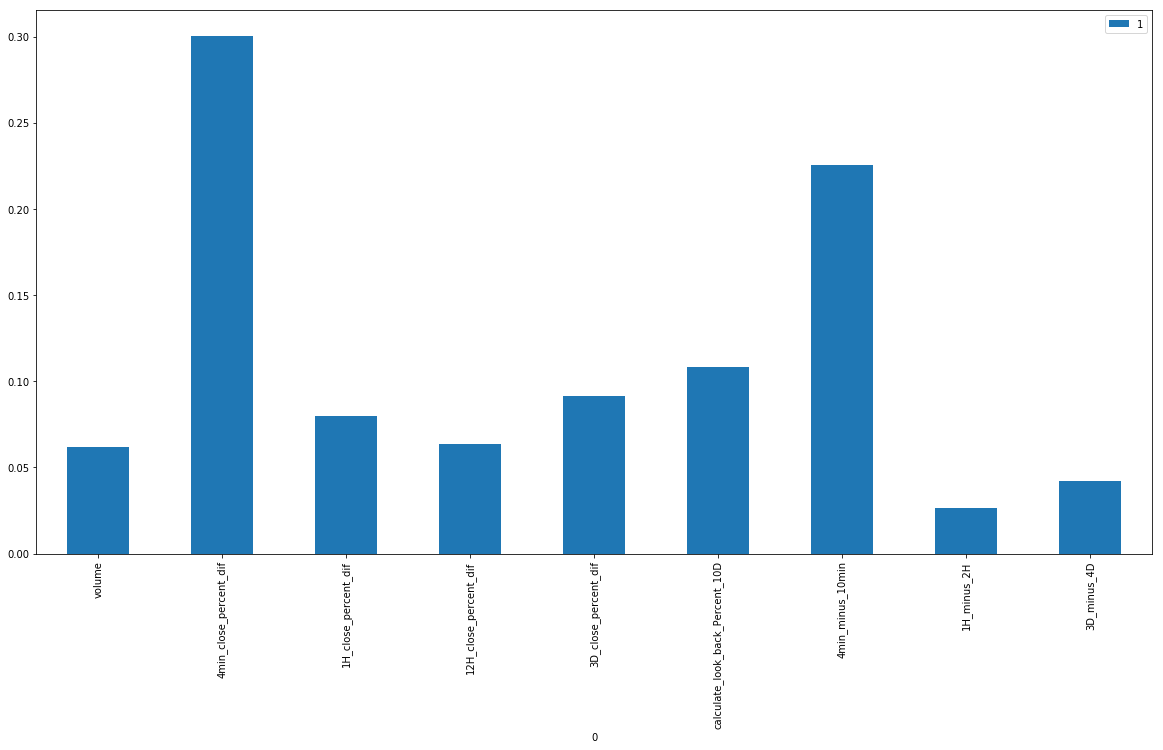

In [350]:
pd.DataFrame([X_train_order.columns, xg_reg.feature_importances_]).T.set_index(0).plot.bar(figsize = (20,10))

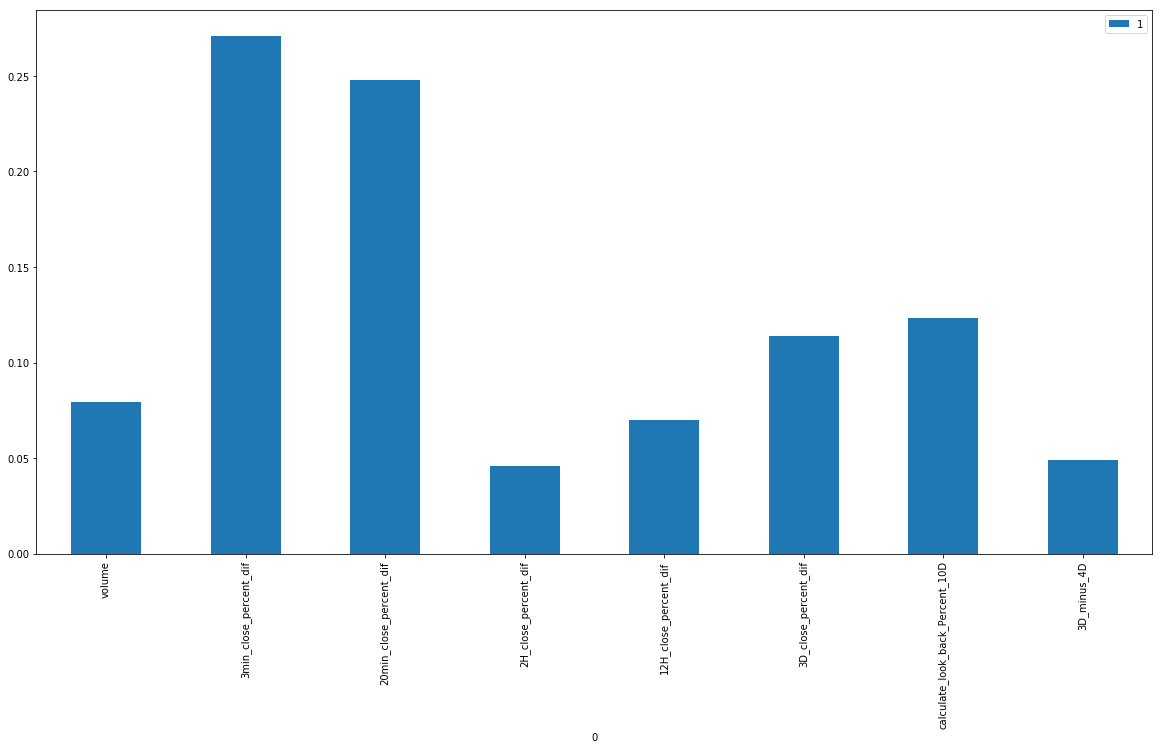

In [192]:
pd.DataFrame([X_train_order.columns, xg_reg.feature_importances_]).T.set_index(0).plot.bar(figsize = (20,10))

'calculate_look_back_Percent_1H',
'calculate_look_back_Percent_4H',
'calculate_look_back_Percent_24H',
'3min_minus_4H',
'3min_minus_24H',
'5min_minus_24H',
'2H_minus_24H',
'12H_minus_3D',

^--- void these features

In [195]:
features_observe = pd.DataFrame([X_train_order.columns, xg_reg.feature_importances_]).T

In [136]:
features_observe[2] = 0.005

In [145]:
# iterate_1_features  = features_observe[features_observe[1] > 0.005][0].values

In [202]:
# iterate_2_features  = [fe for fe in features_observe[0] if fe not in ['calculate_look_back_Percent_1H',
# 'calculate_look_back_Percent_4H',
# 'calculate_look_back_Percent_24H',
# '3min_minus_4H',
# '3min_minus_24H',
# '5min_minus_24H',
# '2H_minus_24H',
# '12H_minus_3D']]

### memory reduction

memory_X_to_train = X_train_order.iloc[:5,:5]

memory_y_to_train = y_train_order[:5]

memory_X_to_test = X_test_order.iloc[:5,:5]
memory_y_to_test = y_test_order[:5]

xg_reg.fit(memory_X_to_train, memory_y_to_train)

preds = xg_reg.predict(memory_X_to_test)

memory_y_to_test

preds

accu_sc = accuracy_score(y_true = memory_y_to_test, y_pred = preds)
print("RMSE: %f" % (accu_sc))

In [ ]:
## Decision Tree

buy_in_decision_classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
buy_in_decision_classifier.fit(X_train_order, y_train_order)

predictions = buy_in_decision_classifier.predict(X_test_order)

accuracy_score(y_true = y_test_order, y_pred = predictions)

for node in [2,3,4,5,6,8,10,12,15,20,25,30]:
    for state_rand in [0,1,42,235,1995]:
        buy_in_decision_classifier = DecisionTreeClassifier(max_leaf_nodes=node, random_state=state_rand)
        buy_in_decision_classifier.fit(X_train_order, y_train_order)

        predictions = buy_in_decision_classifier.predict(X_test_order)

        print('node' , node, 'accuracy', accuracy_score(y_true = y_test_order, y_pred = predictions) , 'sate' , state_rand) 



#1

node = 8
state_rand = 0  #,1,42,235,1995]:
buy_in_decision_classifier = DecisionTreeClassifier(max_leaf_nodes=node, random_state=state_rand)
buy_in_decision_classifier.fit(X_train_order, y_train_order)

predictions = buy_in_decision_classifier.predict(X_test_order)

print(accuracy_score(y_true = y_test_order, y_pred = predictions) , 'sate' , state_rand) 

In [ ]:
xg_reg.predict()

In [ ]:
Counter(predictions)

In [ ]:
Counter(y_test_order['Buy_In'])

In [ ]:
predictions

In [ ]:
dot_data = StringIO()
export_graphviz(buy_in_decision_classifier,
                feature_names=list(X_train_order.columns),
                out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

In [ ]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

In [ ]:
graph.write_png("tree.png")


In [ ]:
Image(graph.create_png())

## Testing theory

In [156]:
XRP_for_testing.head()

,datetime_real,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
0,2019-08-14 23:00:00,1565823600000,0.27050,0.27034,0.27050,0.27032,200.000000,1.565824e+12,60000.0,1.565824e+09
1,2019-08-14 23:01:00,1565823660000,0.27034,0.27014,0.27034,0.27011,6970.610576,1.565824e+12,60000.0,1.565824e+09
2,2019-08-14 23:02:00,1565823720000,0.27015,0.27031,0.27044,0.27015,9002.533511,1.565824e+12,60000.0,1.565824e+09
3,2019-08-14 23:03:00,1565823780000,0.27028,0.27028,0.27034,0.27027,22726.951973,1.565824e+12,60000.0,1.565824e+09
4,2019-08-14 23:04:00,1565823840000,0.27015,0.26971,0.27015,0.26932,115833.923778,1.565824e+12,60000.0,1.565824e+09


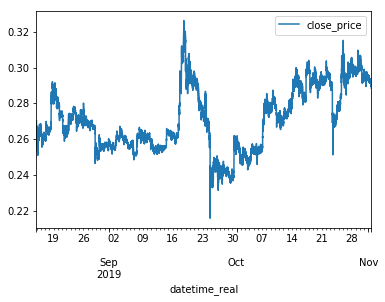

In [157]:
XRP_for_testing[['close_price','datetime_real']].set_index('datetime_real').plot()

In [158]:
section_period = {  '3min': 3,
                    '4min': 4,
                    '5min': 5,
                    '10min': 10,
                    '15min': 15,
                    '20min': 20,
                    '25min': 25,
                    '30min': 30,
                    '35min': 35,
                    '40min': 40,
                    '45min': 45,
                    '50min': 50,
                    '55min': 55,
                    '1H': 60,
                    '2H': 120,
                    '4H': 240,
                    '12H': 720,
                    '24H': 1440,
                    '2D': 2880,
                    '3D': 4320,
                    '4D': 5760,
                    '5D': 7200,
                    '10D': 14400}

In [159]:
for k,v in section_period.items():
    XRP_for_testing['{0}_RA_on_Close'.format(k)] = XRP_for_testing['close_price'].rolling(v).mean()

In [160]:
compare_sequence = {}

In [161]:
for col_1 in [d for d in XRP_for_testing.columns if '_RA_on_Close' in d]:
    for col_2 in [d for d in XRP_for_testing.columns if '_RA_on_Close' in d]:
        temp_1 = col_1.split('_RA_on_Close')[0]
        temp_2 = col_2.split('_RA_on_Close')[0]
        if temp_1 != temp_2:
            if ((temp_1 + '_minus_' + temp_2) not in compare_sequence.keys() and (temp_2 + '_minus_' + temp_1) not in compare_sequence.keys() ):
                compare_sequence.update({temp_1 + '_minus_' + temp_2 : [col_1, col_2]})

In [162]:
for k, val in compare_sequence.items():
    XRP_for_testing[k] = (XRP_for_testing[val[0]] - XRP_for_testing[val[1]])/XRP_for_testing[val[1]] 
#     print(k, val[0], val[1])

In [163]:
for col in [d for d in XRP_for_testing.columns if '_RA_on_Close' in d]:
    XRP_for_testing[col] = XRP_for_testing[col].shift(1)
    
    XRP_for_testing['{0}_close_percent_dif'.format(col.split('_RA_on_Close')[0])] = (XRP_for_testing['close_price']-XRP_for_testing[col])/XRP_for_testing[col] 

In [164]:
for k,v in section_period.items():
    print(k,v)
    XRP_for_testing['look_back_{}'.format(k)] = XRP_for_testing['close_price'].shift(v)   # i.e. 20min ago, this is what the close price is
#     XRP_for_testing['look_forward_{}'.format(k)] = XRP_for_testing['close'].shift(-v)  # i.e. 20min later, the close price is


for k,v in section_period.items():
    print(k,v)
    XRP_for_testing['calculate_look_back_Percent_{}'.format(k)]    = 100*(XRP_for_testing['close_price'] - XRP_for_testing['look_back_{}'.format(k)])/(5*v)
#     XRP_for_testing['calculate_look_forward_Percent_{}'.format(k)] =  100*(XRP_for_testing['look_forward_{}'.format(k)] - XRP_for_testing['close'])/(5*v)

3min 3
4min 4
5min 5
10min 10
15min 15
20min 20
25min 25
30min 30
35min 35
40min 40
45min 45
50min 50
55min 55
1H 60
2H 120
4H 240
12H 720
24H 1440
2D 2880
3D 4320
4D 5760
5D 7200
10D 14400
3min 3
4min 4
5min 5
10min 10
15min 15
20min 20
25min 25
30min 30
35min 35
40min 40
45min 45
50min 50
55min 55
1H 60
2H 120
4H 240
12H 720
24H 1440
2D 2880
3D 4320
4D 5760
5D 7200
10D 14400


In [ ]:
## FInd out WHY:
- XRP_for_testing_drop_na[properties].dropna() is different to XRP_for_testing.dropna()

In [185]:
XRP_for_testing_drop_na = XRP_for_testing.dropna()

In [186]:
Counter(xg_reg.predict(XRP_for_testing_drop_na[properties]))

Counter({False: 86132, True: 12807})

In [187]:
#(buy_in_decision_classifier.predict(XRP_for_testing[properties].dropna()))

In [188]:
len(XRP_for_testing.dropna())

98939

In [189]:
len(XRP_for_testing_drop_na)

98939

In [190]:
len(XRP_for_testing.dropna())

98939

In [191]:
len(xg_reg.predict(XRP_for_testing_drop_na[properties]))

98939